This CEP is created by the following group members:

| Name | Roll Number |
|------|-------------|
| Tooba Aftab | CS22020|
| Bareera Ahsan | CS22030|
| Aqiba Abdul Qadir | CS22003|


# ML CEP: CIFAR-10 Image Classification Models

## Importing Libraries

In [ ]:
import torch
import pickle
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from keras import regularizers
import matplotlib.pyplot as plt
from torchvision import transforms
from sklearn.decomposition import PCA
from torchvision.models import resnet18
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, BatchNormalization, Flatten, Dropout
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score


## Some Useful Functions

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
ind2label_old = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

ind2label_new = {
    0: 'animal',
    1: 'vehicle',
}

In [ ]:
class Model:
    def __init__(self, name, train_acc, train_f1, test_acc, test_f1):
        self.name = name
        self.train_acc = train_acc
        self.train_f1 = train_f1
        self.test_acc = test_acc
        self.test_f1 = test_f1


In [ ]:
def show_some_images(images, title, ind2label):
  plt.figure(figsize=(10,10))
  for i in range(25):
    plt.subplot(5,5,i+1) # rows, cols, index
    ind = random.randint(0, len(images))
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title(ind2label[int(title[ind])])
    plt.imshow(images[ind])


In [ ]:
def show_counts(labels: dict, sett: np.ndarray):
  data = {'label': labels.values(), 'counts': np.unique(sett, return_counts = True)[1]}
  return pd.DataFrame(data)

In [ ]:
def show_graphs(history):

  # Loss Curves
  plt.figure(figsize=[8,6])
  plt.plot(history.history['loss'],'r',linewidth=3.0)
  plt.plot(history.history['val_loss'],'b',linewidth=3.0)
  plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Loss',fontsize=16)
  plt.title('Loss Curves',fontsize=16)

  # Accuracy Curves
  plt.figure(figsize=[8,6])
  plt.plot(history.history['accuracy'],'r',linewidth=3.0)
  plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
  plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Accuracy',fontsize=16)
  plt.title('Accuracy Curves',fontsize=16)

In [ ]:
def get_acc_f1(model, X, y):
  if model[-3:] == 'pkl':
    with open(model, 'rb') as file:
      best_model = pickle.load(file)
  else:
    best_model = load_model(model)
  y_pred = best_model.predict(X)
  y_pred = y_pred > 0.5

  acc = accuracy_score(y, y_pred)
  f1 = f1_score(y, y_pred)

  return acc, f1, y_pred

In [ ]:
def show_conf_matrix(model, X_test, y_test):

  acc, f1, y_pred = get_acc_f1(model, X_test, y_test)

  print("\nAccuracy: ", round(acc * 100, 2), '%', sep='')
  print("F1 Score: ", round(f1 * 100, 2), '%', sep='', end='\n\n')

  conf_matrix = confusion_matrix(y_test, y_pred)
  plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
              xticklabels=['Animal', 'Vehicle'], yticklabels=['Animal', 'Vehicle']) # Adjust labels as needed
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Confusion Matrix')
  plt.show()

In [ ]:
def draw_table(lst):
    return pd.DataFrame({
    'Model Name':[i.name for i in lst],
    'Train Accuracy':[round(i.train_acc*100,2) for i in lst],
    'Train F1-Score':[round(i.train_f1*100,2) for i in lst],
    'Test Accuracy':[round(i.test_acc*100,2) for i in lst],
    'Test F1-Score':[round(i.test_f1*100,2) for i in lst],
}).set_index('Model Name')

In [ ]:
def plot_scores(lst):
  fig, ax = plt.subplots(figsize=(10,6))
  plot = sns.barplot(x=[i.name for i in lst],y=[i.train_acc for i in lst])
  plt.xticks(rotation=45)
  plt.title("Train Accuracy")
  plot.set_ylim((0.4,1))

  fig, ax = plt.subplots(figsize=(10,6))
  plot = sns.barplot(x=[i.name for i in lst],y=[i.train_f1 for i in lst])
  plt.xticks(rotation=45)
  plt.title("Train F1 score")
  plot.set_ylim((0.4,1))

  fig, ax = plt.subplots(figsize=(10,6))
  plot = sns.barplot(x=[i.name for i in lst],y=[i.test_acc for i in lst])
  plt.xticks(rotation=45)
  plt.title("Test Accuracy")
  plot.set_ylim((0.4,1))

  fig, ax = plt.subplots(figsize=(10,6))
  plot = sns.barplot(x=[i.name for i in lst],y=[i.test_f1 for i in lst])
  plt.xticks(rotation=45)
  plt.title("Test F1 score")
  plot.set_ylim((0.4,1))

## Exploring the dataset

In [ ]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


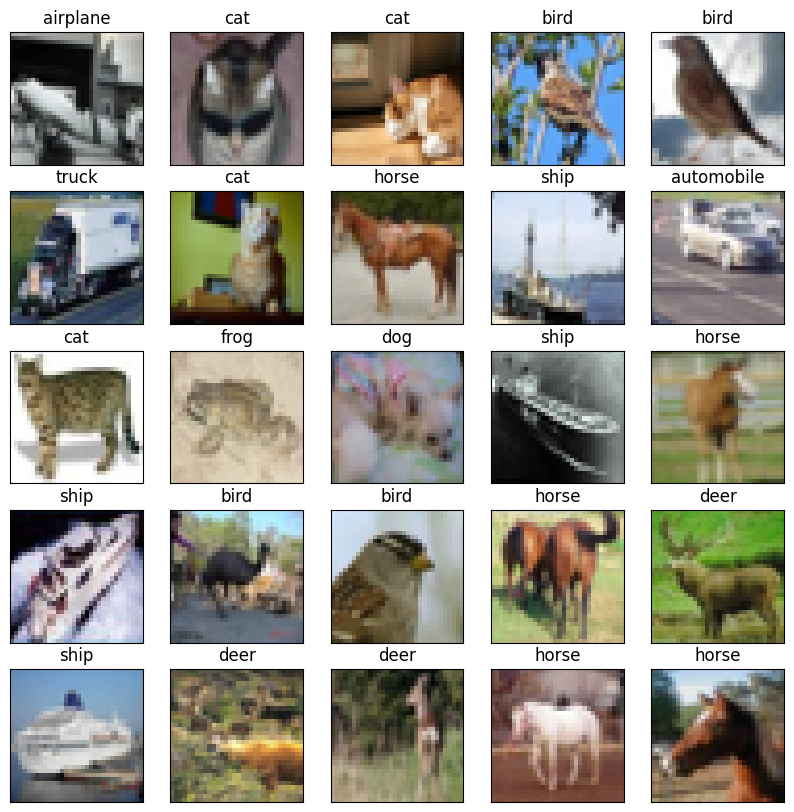

In [ ]:
show_some_images(X_train, y_train, ind2label_old)

We can observe that there are different types of images in this dataset. Let's count how many.

In [ ]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

So CIFAR 10 has 10 types of images. We have to convert the labels such that they become binary. From the website, we get to know the mapping of each label as follows:

- 0: airplane
- 1: automobile
- 2: bird
- 3: cat
- 4: deer
- 5: dog
- 6: frog
- 7: horse
- 8: ship
- 9: truck

In [ ]:
show_counts(ind2label_old, y_train)

,label,counts
0,airplane,5000
1,automobile,5000
2,bird,5000
3,cat,5000
4,deer,5000
5,dog,5000
6,frog,5000
7,horse,5000
8,ship,5000
9,truck,5000


In [ ]:
show_counts(ind2label_old, y_test)

,label,counts
0,airplane,1000
1,automobile,1000
2,bird,1000
3,cat,1000
4,deer,1000
5,dog,1000
6,frog,1000
7,horse,1000
8,ship,1000
9,truck,1000


The dataset is balanced with a ratio of 1/6 is test set and 5/6 in train set.<br/>
But there are 4 vehicle classes and 6 animal classes.

Now, let's check the image size

In [ ]:
X_train[0].shape

(32, 32, 3)

It's a 32x32 RGB image.
The total features will be 32 x 32 x 3 = 3,072

In [ ]:
print("Shape of X Train Set:", X_train.shape)
print("Shape of y Train Set:", y_train.shape)
print("Shape of X Test Set:", X_test.shape)
print("Shape of y Test Set:", y_test.shape)

Shape of X Train Set: (50000, 32, 32, 3)
Shape of y Train Set: (50000, 1)
Shape of X Test Set: (10000, 32, 32, 3)
Shape of y Test Set: (10000, 1)


## Preprocessing the dataset

Some ideas we have in mind include:
- converting multiclass to binary single class
- simplifying the features
- reducing the features
- creating a validation set



### Binarising the labels

In [ ]:
def binarise(x):
  return x in [0,1,8,9] # vehicle is labelled 1 and animal is labelled 0
binarise = np.vectorize(binarise)

In [ ]:
y_train_bin = binarise(y_train)
y_test_bin = binarise(y_test)

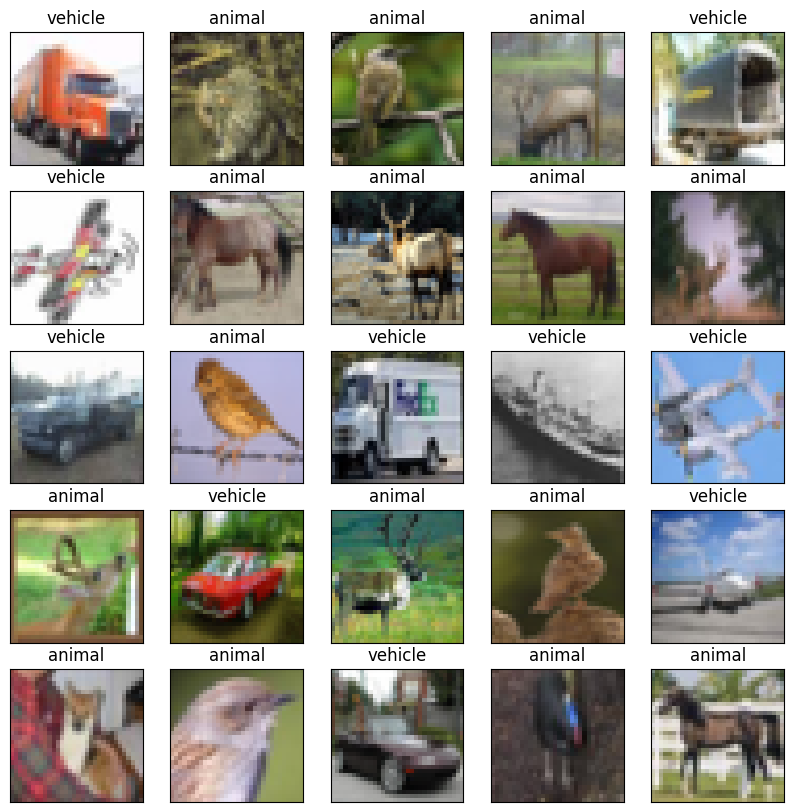

In [ ]:
show_some_images(X_train, y_train_bin, ind2label_new)

### Image Preprocessing

Some Image Preprocessing measures include:
- Grayscale conversion
- Data Augmentation
- Image Scaling
- Image Flattening

We'll go with gray-scale conversion, scaling and flattening the images.

#### Flattening

In [ ]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

In [ ]:
print("Shape of X Train Set:", X_train_flat.shape)
print("Shape of y Train Set:", y_train_bin.shape)
print("Shape of X Test Set:", X_test_flat.shape)
print("Shape of y Test Set:", y_test_bin.shape)

Shape of X Train Set: (50000, 3072)
Shape of y Train Set: (50000, 1)
Shape of X Test Set: (10000, 3072)
Shape of y Test Set: (10000, 1)


#### Scaling

In [ ]:
X_train_scale = X_train_flat/255
X_test_scale = X_test_flat/255

#### Gray Scale

In [ ]:
def rgb2gray(rgb):
    r, g, b = rgb[...,0], rgb[...,1], rgb[...,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

In [ ]:
X_train_gray = rgb2gray(X_train)
X_test_gray = rgb2gray(X_test)

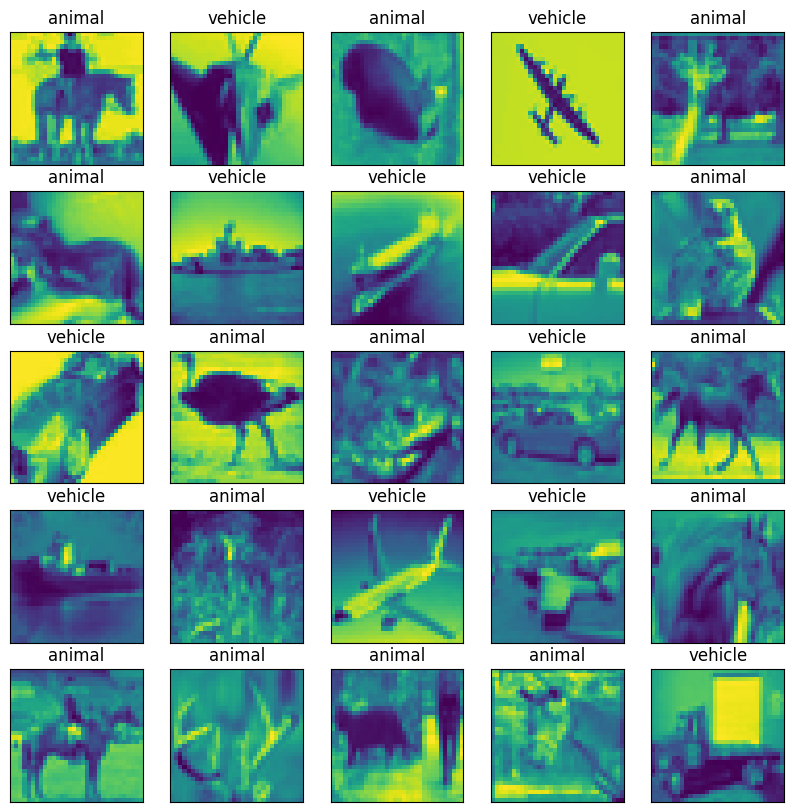

In [ ]:
show_some_images(X_train_gray, y_train_bin, ind2label_new)

In [ ]:
print("Shape of X Train Set:", X_train_gray.shape)
print("Shape of y Train Set:", y_train_bin.shape)
print("Shape of X Test Set:", X_test_gray.shape)
print("Shape of y Test Set:", y_test_bin.shape)

Shape of X Train Set: (50000, 32, 32)
Shape of y Train Set: (50000, 1)
Shape of X Test Set: (10000, 32, 32)
Shape of y Test Set: (10000, 1)


#### Flattened Gray Scale

In [ ]:
X_train_gray_flat = X_train_gray.reshape(X_train_gray.shape[0], -1)
X_test_gray_flat = X_test_gray.reshape(X_test_gray.shape[0], -1)

In [ ]:
print("Shape of X Train Set:", X_train_gray_flat.shape)
print("Shape of y Train Set:", y_train_bin.shape)
print("Shape of X Test Set:", X_test_gray_flat.shape)
print("Shape of y Test Set:", y_test_bin.shape)

Shape of X Train Set: (50000, 1024)
Shape of y Train Set: (50000, 1)
Shape of X Test Set: (10000, 1024)
Shape of y Test Set: (10000, 1)


#### Scaled Flattened Gray Scale

In [ ]:
X_train_gray_flat_scale = X_train_gray_flat/255
X_test_gray_flat_scale = X_test_gray_flat/255

#### Applying PCA

In [ ]:
pca_dims = PCA()
pca_dims.fit(X_train_gray_flat_scale)
cumsum = np.cumsum(pca_dims.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.98) + 1

In [ ]:
print("The reduced dimensions after applying PCA to gray scaled flattened images is:", d)

The reduced dimensions after applying PCA to gray scaled flattened images is: 160


In [ ]:
pca_dims_2 = PCA()
pca_dims_2.fit(X_train_scale)
cumsum2 = np.cumsum(pca_dims.explained_variance_ratio_)
d2 = np.argmax(cumsum >= 0.95) + 1

In [ ]:
print("The reduced dimensions after applying PCA to RGB scaled flattened images is:", d2)

The reduced dimensions after applying PCA to RGB scaled flattened images is: 160


In [ ]:
pca_final = PCA(n_components=d)
X_reduced = pca_final.fit_transform(X_train_gray_flat_scale)
X_recovered = pca_final.inverse_transform(X_reduced)

In [ ]:
X_test_reduced = pca_final.fit_transform(X_test_gray_flat_scale)
X_test_recovered = pca_final.inverse_transform(X_test_reduced)

In [ ]:
print("Train reduced shape:", X_reduced.shape)
print("Train recovered shape: ", X_recovered.shape)
print("Test reduced shape:", X_test_reduced.shape)
print("Test recovered shape: ", X_test_recovered.shape)

Train reduced shape: (50000, 160)
Train recovered shape:  (50000, 1024)
Test reduced shape: (10000, 160)
Test recovered shape:  (10000, 1024)


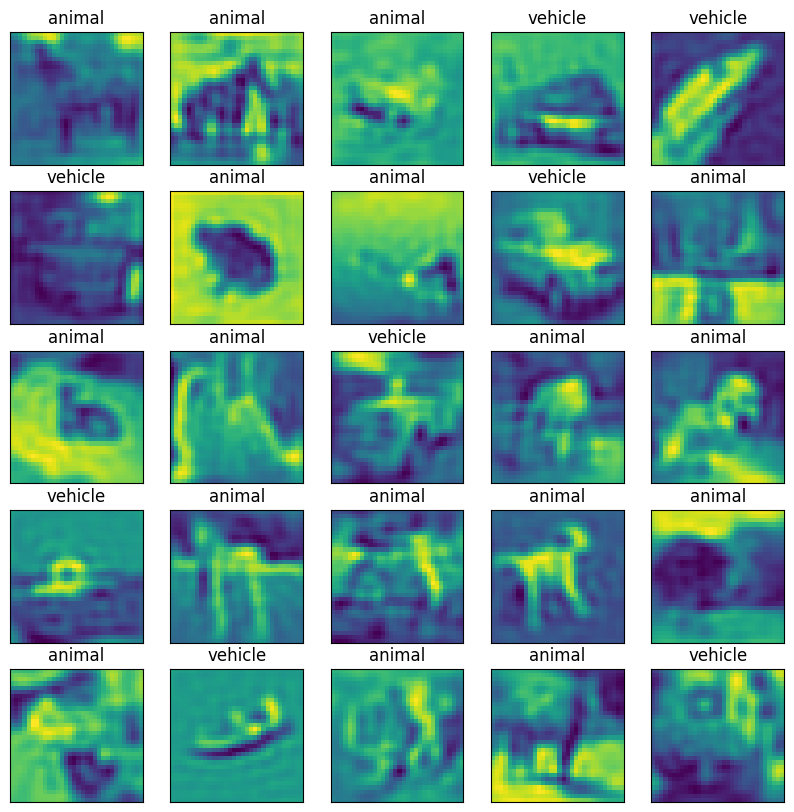

In [ ]:
show_some_images(X_recovered.reshape(50000,32,32), y_train_bin, ind2label_new)

This seems to have reduced many features.

#### Creating a new split

We had an auto split of 50,000 images in train set and 10,000 images in test set. I'll now pick 10,000 images from the train set and shift it to test set.

In [ ]:
np.unique(y_train_bin[40000:], return_counts=True)

(array([False,  True]), array([5947, 4053]))

In [ ]:
new_X_train = X_train[:40000]
new_y_train_bin = y_train_bin[:40000]
new_X_test = np.concatenate((X_train[40000:], X_test))
new_y_test_bin = np.concatenate((y_train_bin[40000:], y_test_bin))
print('Length of new train set:', len(new_X_train))
print('Length of new test set:', len(new_X_test))

Length of new train set: 40000
Length of new test set: 20000


In [ ]:
new_X_train_flat = new_X_train.reshape(new_X_train.shape[0], -1)
new_X_test_flat = new_X_test.reshape(new_X_test.shape[0], -1)

In [ ]:
new_X_train_scale = new_X_train_flat / 255
new_X_test_scale = new_X_test_flat / 255

In [ ]:
print('Shape of new scaled X train set:', new_X_train_scale.shape)
print('Shape of new scaled X test set:', new_X_test_scale.shape)
print('Shape of new y train set:', new_y_train_bin.shape)
print('Shape of new y test set:', new_y_test_bin.shape)

Shape of new scaled X train set: (40000, 3072)
Shape of new scaled X test set: (20000, 3072)
Shape of new y train set: (40000, 1)
Shape of new y test set: (20000, 1)


#### Scaling for ANNs

In [ ]:
X_train_scaled = X_train / 255.0
X_test_scaled = X_test / 255.0

## Model Training

### Model 1: Artificial Neural Network

#### 1a. With two hidden Layers and RMSProp Optimiser

In [ ]:
model1a = Sequential([
    Flatten(input_shape=(32,32,3)),
    Dense(300, activation='relu'),
    BatchNormalization(),
    Dense(100, activation='relu'),
    Dense(1, activation= 'sigmoid'),
])


In [ ]:
model1a.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_4 (Flatten)             │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 300)            │       921,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 300)            │         1,200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 953,301 (3.64 MB)

 Trainable params: 952,701 (3.63 MB)

 Non-trainable params: 600 (2.34 KB)

In [ ]:
METRICS = [
    'f1_score',
    'accuracy',
    'precision',
    'recall',
]
model1a.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=METRICS)

In [ ]:
checkpoint1a = ModelCheckpoint(filepath="model1a.keras", monitor="val_accuracy", save_best_only=True)
batch_size = 32
history1a = model1a.fit(X_train_scaled, y_train_bin,
              epochs=20,
              validation_data=(X_test_scaled, y_test_bin),
              callbacks=[checkpoint1a],
              batch_size=batch_size,
              verbose=1,
             )

Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9140 - f1_score: 0.5706 - loss: 0.2118 - precision: 0.9001 - recall: 0.8826 - val_accuracy: 0.8616 - val_f1_score: 0.5714 - val_loss: 0.4337 - val_precision: 0.9050 - val_recall: 0.7308
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9152 - f1_score: 0.5714 - loss: 0.2109 - precision: 0.9031 - recall: 0.8826 - val_accuracy: 0.8567 - val_f1_score: 0.5715 - val_loss: 0.4442 - val_precision: 0.8076 - val_recall: 0.8425
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9187 - f1_score: 0.5691 - loss: 0.2053 - precision: 0.9045 - recall: 0.8896 - val_accuracy: 0.8675 - val_f1_score: 0.5720 - val_loss: 0.3908 - val_precision: 0.8453 - val_recall: 0.8185
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9145 - f1_score: 0.5692 - loss: 0.2117 - precision: 0.9021 - recall: 0.8807 - val_accuracy: 0.8628 - val_f1_score: 0.5717 - val_loss: 0.4294 - val_precision: 0.8546 - val

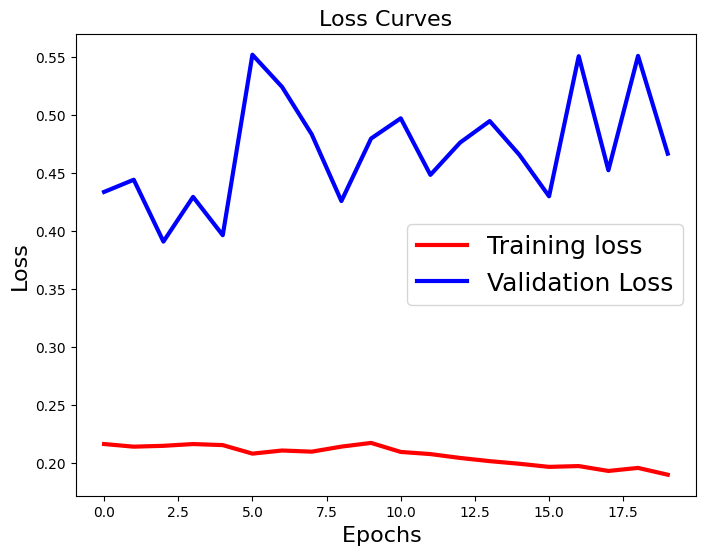

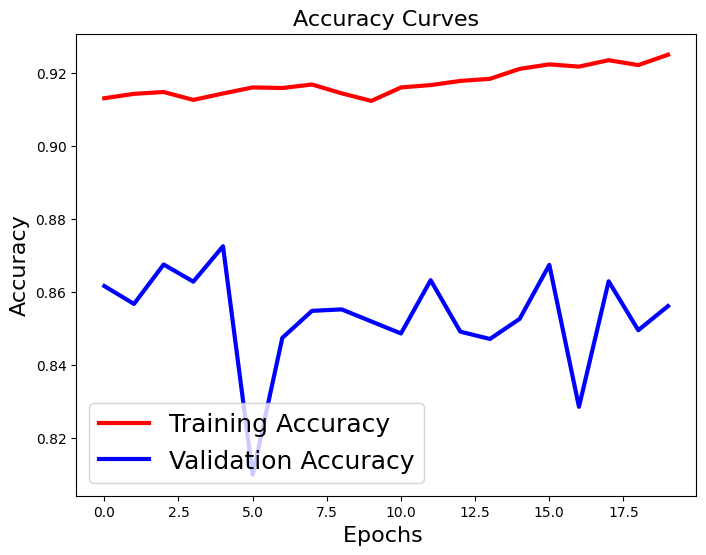

In [ ]:
show_graphs(history1a)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Accuracy: 87.25%
F1 Score: 83.47%



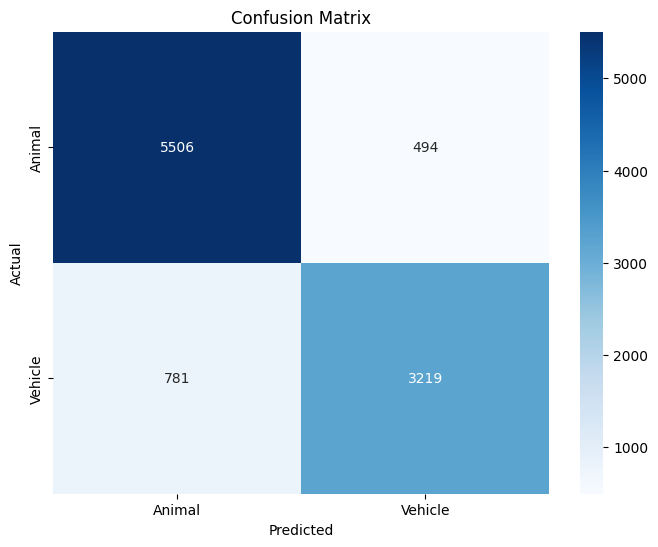

In [ ]:
show_conf_matrix('model1a.keras', X_test_scaled, y_test_bin)

#### 1b. With four hidden Layers and Adam Optimiser. It is trained with unscaled images.

In [ ]:
model1b = Sequential([
    Flatten(input_shape=(32, 32, 3)),
    Dense(1024, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.002)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.003)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.1),
    Dense(1, activation='sigmoid')
])

In [ ]:
METRICS = [
    'f1_score',
    'accuracy',
    'recall',
    'precision',
]

model1b.compile(loss='binary_crossentropy',
                optimizer= Adam(learning_rate=0.008),
                metrics=METRICS)
model1b.summary()


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_13 (Flatten)            │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 1024)           │     3,146,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,852,033 (14.69 MB)

 Trainable params: 3,848,065 (14.68 MB)

 Non-trainable params: 3,968 (15.50 KB)

In [ ]:
checkpoint1b = ModelCheckpoint(filepath="model1b.keras", monitor="val_loss", save_best_only=True)
batch_size = 128
history1b = model1b.fit(X_train, y_train_bin,
              epochs=50,
              validation_data=(X_test, y_test_bin),
              callbacks=[checkpoint1b],
              batch_size=batch_size,
              verbose=1,
             )

Epoch 1/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8843 - f1_score: 0.5710 - loss: 0.3409 - precision: 0.8606 - recall: 0.8477 - val_accuracy: 0.8772 - val_f1_score: 0.5715 - val_loss: 0.3431 - val_precision: 0.8557 - val_recall: 0.8335
Epoch 2/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8841 - f1_score: 0.5738 - loss: 0.3396 - precision: 0.8621 - recall: 0.8475 - val_accuracy: 0.8764 - val_f1_score: 0.5715 - val_loss: 0.3713 - val_precision: 0.8311 - val_recall: 0.8673
Epoch 3/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8838 - f1_score: 0.5697 - loss: 0.3391 - precision: 0.8582 - recall: 0.8486 - val_accuracy: 0.8697 - val_f1_score: 0.5714 - val_loss: 0.3603 - val_precision: 0.8321 - val_recall: 0.8447
Epoch 4/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8822 - f1_score: 0.5747 - loss: 0.3417 - precision: 0.8606 - recall: 0.8446 - val_accuracy: 0.8713 - val_f1_score: 0.5714 - val_loss: 0.3580 - val_precision: 0.8300 - val_recall:

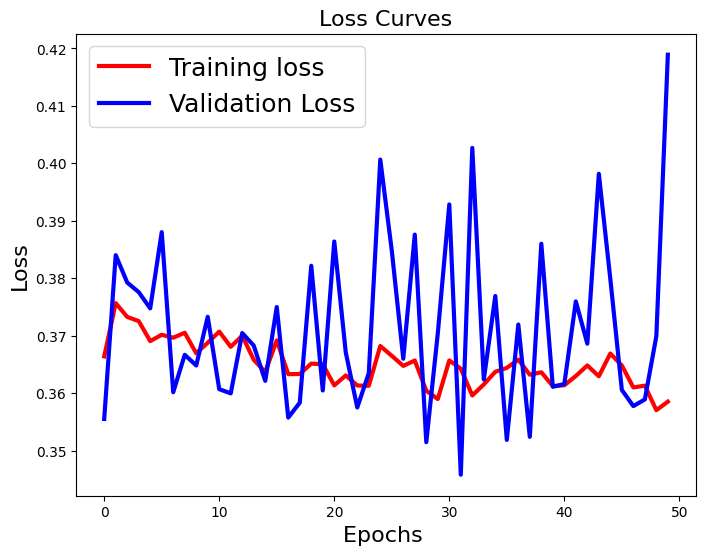

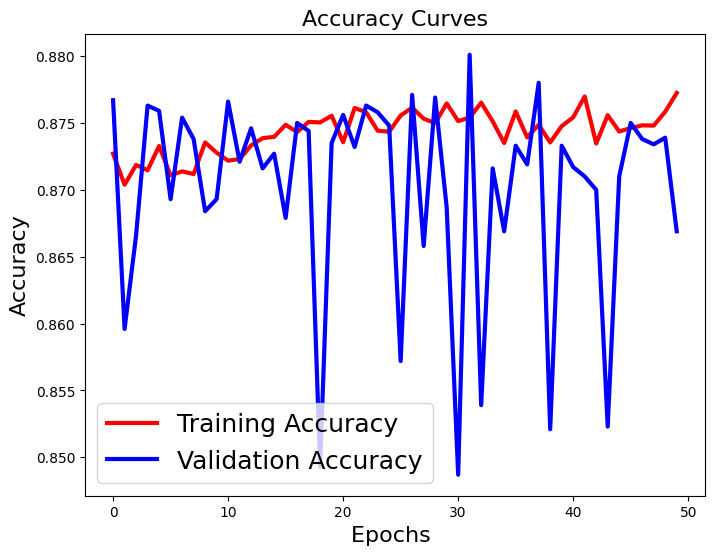

In [ ]:
show_graphs(history1b)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Accuracy: 88.01%
F1 Score: 84.94%



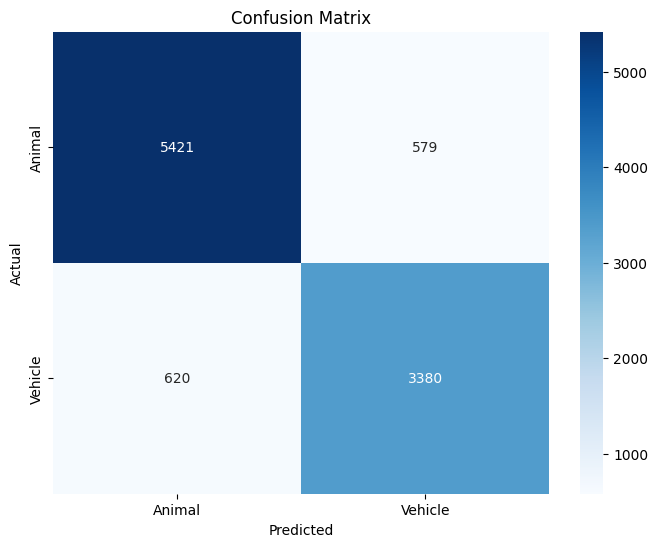

In [ ]:
show_conf_matrix('model1b.keras', X_test, y_test_bin)

#### 1c. With different neurons in hidden Layers and RMSProp Optimiser

In [ ]:
model1c = Sequential([
    Flatten(input_shape=(32,32,3)),
    Dense(400, activation='relu'),
    BatchNormalization(),
    Dense(200, activation='relu'),
    BatchNormalization(),
    Dense(1, activation= 'sigmoid'),
])

In [ ]:
model1c.compile(loss='binary_crossentropy',
                optimizer='rmsprop',
                metrics=METRICS)
model1c.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_5 (Flatten)             │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 400)            │     1,229,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 400)            │         1,600 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 200)            │        80,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,312,001 (5.00 MB)

 Trainable params: 1,310,801 (5.00 MB)

 Non-trainable params: 1,200 (4.69 KB)

In [ ]:
checkpoint1c = ModelCheckpoint(filepath="model1c.keras", monitor="val_accuracy", save_best_only=True)
batch_size = 32
history1c = model1c.fit(X_train_scaled, y_train_bin, epochs=30,
                        validation_data = (X_test_scaled, y_test_bin),
                        verbose=1, batch_size = batch_size,
                        callbacks=[checkpoint1c])

Epoch 1/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.8042 - f1_score: 0.5715 - loss: 0.4484 - precision: 0.7669 - recall: 0.7355 - val_accuracy: 0.8043 - val_f1_score: 0.5714 - val_loss: 0.4401 - val_precision: 0.7121 - val_recall: 0.8575
Epoch 2/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8486 - f1_score: 0.5716 - loss: 0.3562 - precision: 0.8254 - recall: 0.7882 - val_accuracy: 0.8307 - val_f1_score: 0.5714 - val_loss: 0.3889 - val_precision: 0.8828 - val_recall: 0.6650
Epoch 3/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8566 - f1_score: 0.5714 - loss: 0.3389 - precision: 0.8344 - recall: 0.8004 - val_accuracy: 0.8578 - val_f1_score: 0.5715 - val_loss: 0.3437 - val_precision: 0.8072 - val_recall: 0.8468
Epoch 4/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8615 - f1_score: 0.5730 - loss: 0.3308 - precision: 0.8418 - recall: 0.8069 - val_accuracy: 0.8385 - val_f1_score: 0.5714 - val_loss: 0.4053 - val_precision: 0.7706 - va

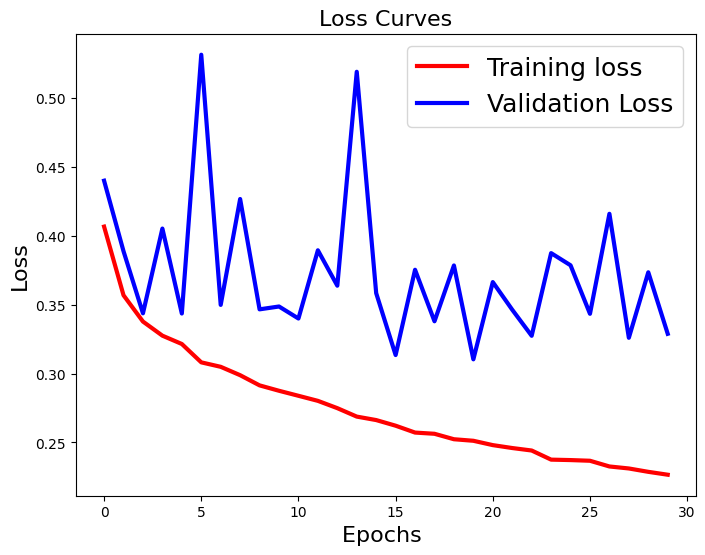

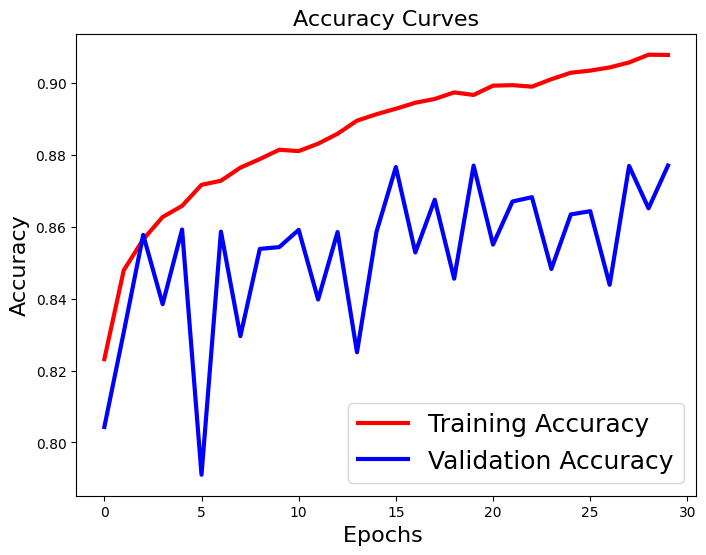

In [ ]:
show_graphs(history1c)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Accuracy: 87.71%
F1 Score: 84.04%



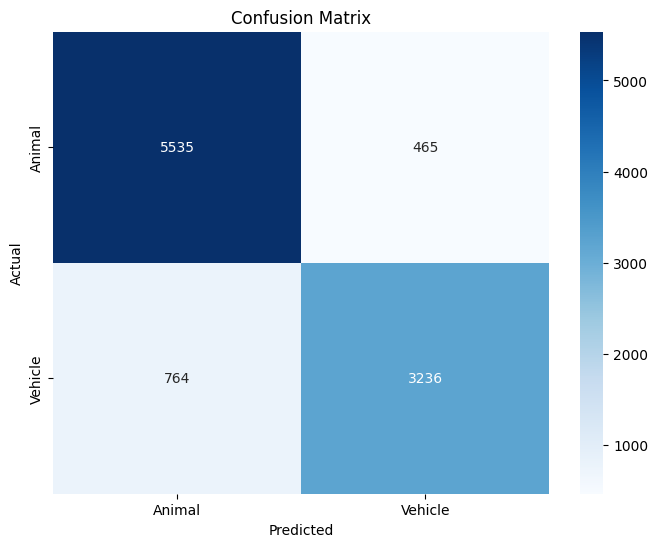

In [ ]:
show_conf_matrix('model1c.keras', X_test_scaled, y_test_bin)

#### 1d. With three hidden Layers and Adam Optimiser(not scaled images)

In [ ]:
model1d = Sequential([
    Flatten(input_shape=(32,32,3)),
    Dense(400, activation='relu'),
    BatchNormalization(),
    Dense(200, activation='relu'),
    BatchNormalization(),
    Dense(100, activation='relu'),
    BatchNormalization(),
    Dense(1, activation= 'sigmoid'),
])

In [ ]:
model1d.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=METRICS)
model1d.summary()

Model: "sequential_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_53 (Flatten)            │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_169 (Dense)               │ (None, 400)            │     1,229,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_80          │ (None, 400)            │         1,600 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_170 (Dense)               │ (None, 200)            │        80,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_81          │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_171 (Dense)               │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_82          │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_172 (Dense)               │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,332,401 (5.08 MB)

 Trainable params: 1,331,001 (5.08 MB)

 Non-trainable params: 1,400 (5.47 KB)

In [ ]:
checkpoint1d = ModelCheckpoint(filepath="model1d.keras", monitor="val_loss", save_best_only=True)
batch_size = 64
history1d = model1d.fit(X_train, y_train_bin, epochs=40,
                        validation_data = (X_test, y_test_bin),
                        verbose=1, batch_size = batch_size,
                        callbacks=[checkpoint1d])

Epoch 1/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9837 - loss: 0.0440 - precision: 0.9787 - recall: 0.9804 - val_accuracy: 0.8616 - val_loss: 1.9860 - val_precision: 0.8126 - val_recall: 0.8500
Epoch 2/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9898 - loss: 0.0287 - precision: 0.9874 - recall: 0.9869 - val_accuracy: 0.8597 - val_loss: 2.3777 - val_precision: 0.7978 - val_recall: 0.8698
Epoch 3/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9883 - loss: 0.0325 - precision: 0.9850 - recall: 0.9855 - val_accuracy: 0.8680 - val_loss: 2.2386 - val_precision: 0.8406 - val_recall: 0.8267
Epoch 4/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9894 - loss: 0.0291 - precision: 0.9854 - recall: 0.9880 - val_accuracy: 0.8494 - val_loss: 2.0553 - val_precision: 0.7782 - val_recall: 0.8720
Epoch 5/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9889 - loss: 0.0316 - precision: 0.9861 - recall: 0.9859 - val_accuracy: 0.8591 - val_loss: 1.

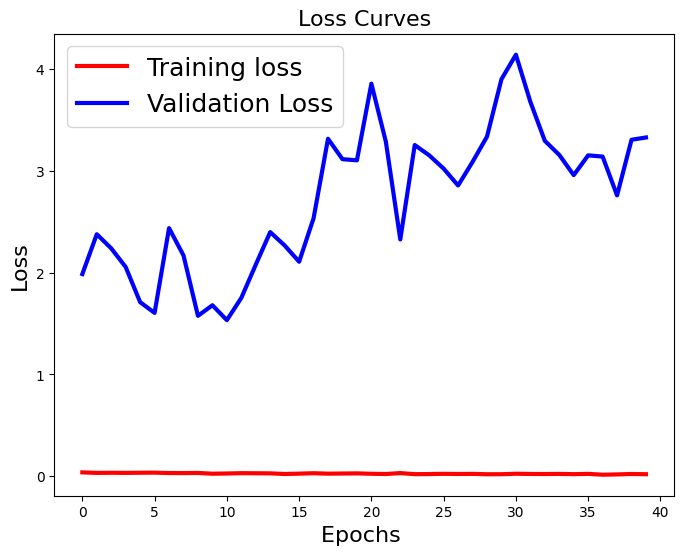

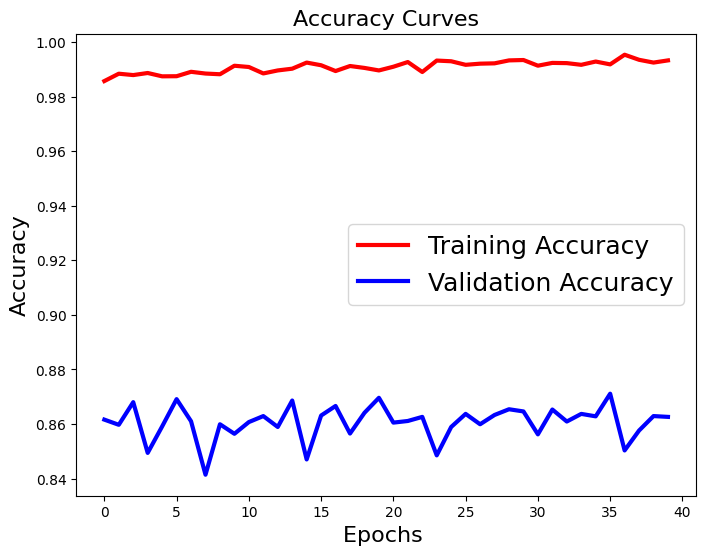

In [ ]:
show_graphs(history1d)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Accuracy: 86.07%
F1 Score: 82.51%



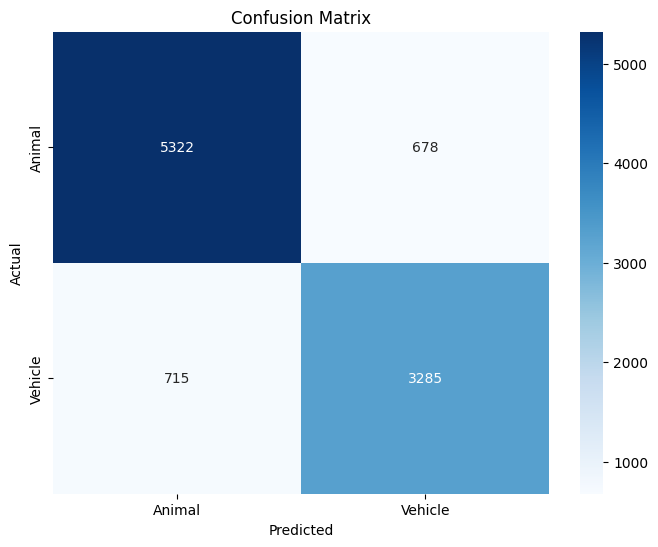

In [ ]:
show_conf_matrix('model1d.keras', X_test, y_test_bin)

This model seems to be overfit since around 99% of training accuracy is observed but validation accuracy lags behind.

#### 1e. Regularising model 1d(not scaled images)

In [ ]:
model1e = Sequential([
    Flatten(input_shape=(32,32,3)),
    Dense(400, activation='relu'),
    BatchNormalization(),
    Dense(200, activation='relu', kernel_regularizer=regularizers.l2(0.05)),
    BatchNormalization(),
    Dense(100, activation='relu', kernel_regularizer=regularizers.l2(0.02)),
    BatchNormalization(),
    Dense(1, activation= 'sigmoid'),
])

In [ ]:
model1e.compile(loss='binary_crossentropy',
                optimizer='rmsprop',
                metrics=METRICS)
model1e.summary()

Model: "sequential_55"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_58 (Flatten)            │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_185 (Dense)               │ (None, 400)            │     1,229,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_92          │ (None, 400)            │         1,600 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_186 (Dense)               │ (None, 200)            │        80,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_93          │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_187 (Dense)               │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_94          │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_188 (Dense)               │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,332,401 (5.08 MB)

 Trainable params: 1,331,001 (5.08 MB)

 Non-trainable params: 1,400 (5.47 KB)

In [ ]:
checkpoint1e = ModelCheckpoint(filepath="model1e.keras", monitor="val_accuracy", save_best_only=True)
batch_size = 64
history1e = model1e.fit(X_train, y_train_bin, epochs=40,
                        validation_data = (X_test, y_test_bin),
                        verbose=1, batch_size = batch_size,
                        callbacks=[checkpoint1e])

Epoch 1/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8014 - loss: 3.2105 - precision: 0.7585 - recall: 0.7753 - val_accuracy: 0.7832 - val_loss: 0.5202 - val_precision: 0.7031 - val_recall: 0.7928
Epoch 2/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8393 - loss: 0.4091 - precision: 0.8027 - recall: 0.7891 - val_accuracy: 0.7011 - val_loss: 0.6486 - val_precision: 0.5785 - val_recall: 0.9315
Epoch 3/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8500 - loss: 0.3740 - precision: 0.8146 - recall: 0.8054 - val_accuracy: 0.8349 - val_loss: 0.4009 - val_precision: 0.7567 - val_recall: 0.8655
Epoch 4/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8558 - loss: 0.3556 - precision: 0.8210 - recall: 0.8142 - val_accuracy: 0.8347 - val_loss: 0.4001 - val_precision: 0.7660 - val_recall: 0.8447
Epoch 5/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8574 - loss: 0.3469 - precision: 0.8218 - recall: 0.8182 - val_accuracy: 0.8076 - val_loss: 0.

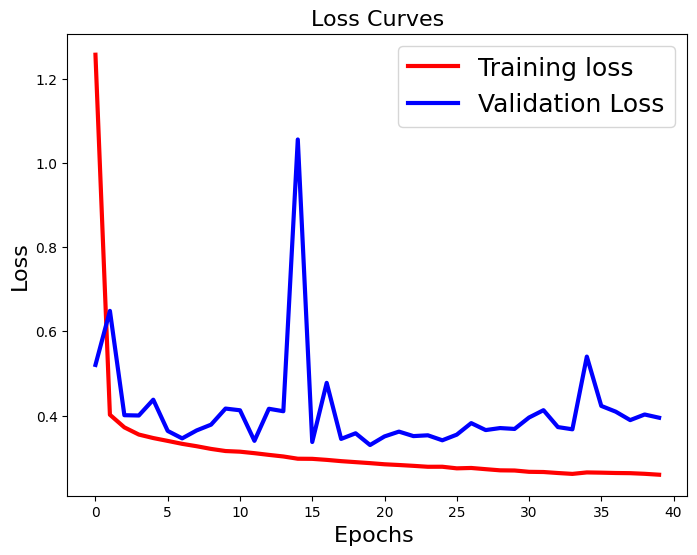

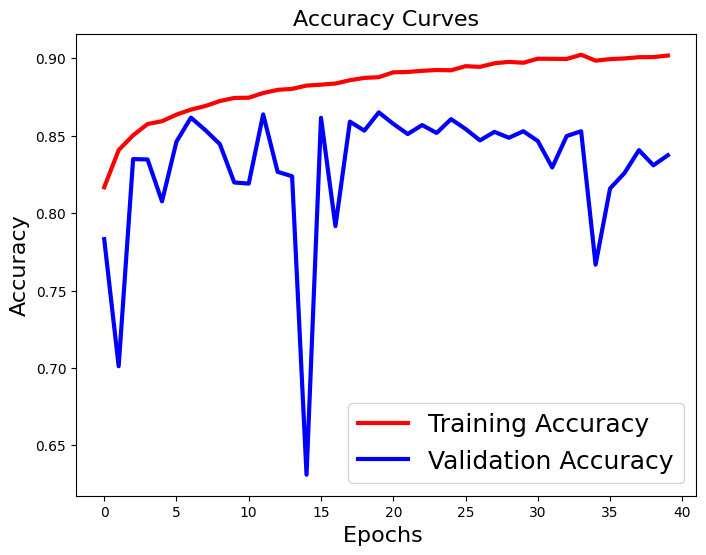

In [ ]:
show_graphs(history1e)

Now, it's better!

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Accuracy: 86.51%
F1 Score: 82.47%



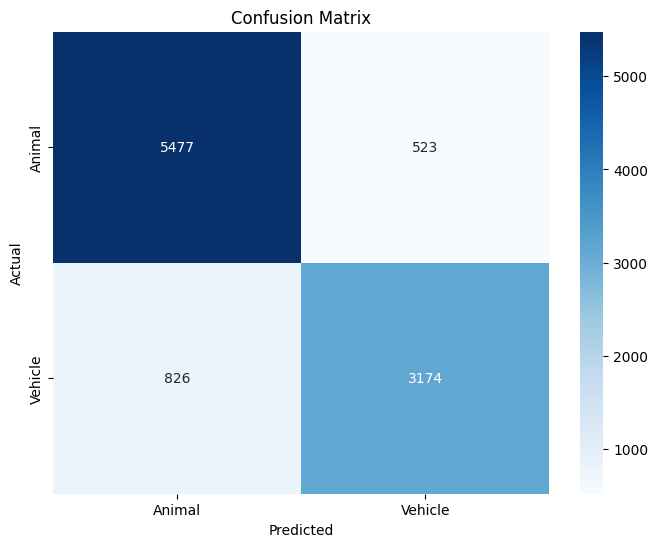

In [ ]:
show_conf_matrix('model1e.keras', X_test, y_test_bin)

#### 1f. Experimenting with he kernel initialiser


In [ ]:
model1f = Sequential([
    Flatten(input_shape=(32, 32, 3)),
    Dense(1024, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.002)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

In [ ]:
METRICS = [
    'f1_score',
    'recall',
    'accuracy',
    'precision',
]
model1f.compile(loss='binary_crossentropy',
                optimizer='rmsprop',
                metrics=METRICS)
model1f.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1024)           │     3,146,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,810,305 (14.54 MB)

 Trainable params: 3,806,721 (14.52 MB)

 Non-trainable params: 3,584 (14.00 KB)

In [ ]:
checkpoint1f = ModelCheckpoint(filepath="model1f.keras", monitor="val_loss", save_best_only=True)
batch_size = 64
epochs = 100
# history1f = model1f.fit(X_train, y_train_bin, epochs=40,
#                         validation_data = (X_test, y_test_bin),
#                         verbose=1, batch_size = batch_size,
#                         callbacks=[checkpoint1f])

history1f = model1f.fit(
    X_train_scaled, y_train_bin,
    epochs=epochs,
    validation_data=(X_test_scaled, y_test_bin),
    callbacks=[checkpoint1f]
)

Epoch 1/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8320 - f1_score: 0.5728 - loss: 0.4109 - precision: 0.7961 - recall: 0.7818 - val_accuracy: 0.8298 - val_f1_score: 0.5714 - val_loss: 0.4306 - val_precision: 0.8858 - val_recall: 0.6595
Epoch 2/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8294 - f1_score: 0.5747 - loss: 0.4171 - precision: 0.7937 - recall: 0.7794 - val_accuracy: 0.8449 - val_f1_score: 0.5714 - val_loss: 0.3807 - val_precision: 0.8091 - val_recall: 0.8012
Epoch 3/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8318 - f1_score: 0.5693 - loss: 0.4121 - precision: 0.7971 - recall: 0.7742 - val_accuracy: 0.8411 - val_f1_score: 0.5714 - val_loss: 0.4010 - val_precision: 0.8831 - val_recall: 0.6948
Epoch 4/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8335 - f1_score: 0.5699 - loss: 0.4093 - precision: 0.7989 - recall: 0.7784 - val_accuracy: 0.8507 - val_f1_score: 0.5714 - val_loss: 0.3801 - val_precision: 0.8317 

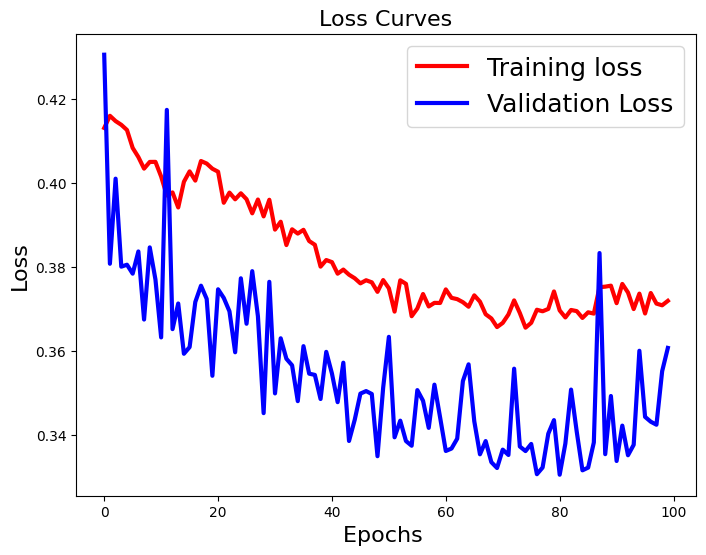

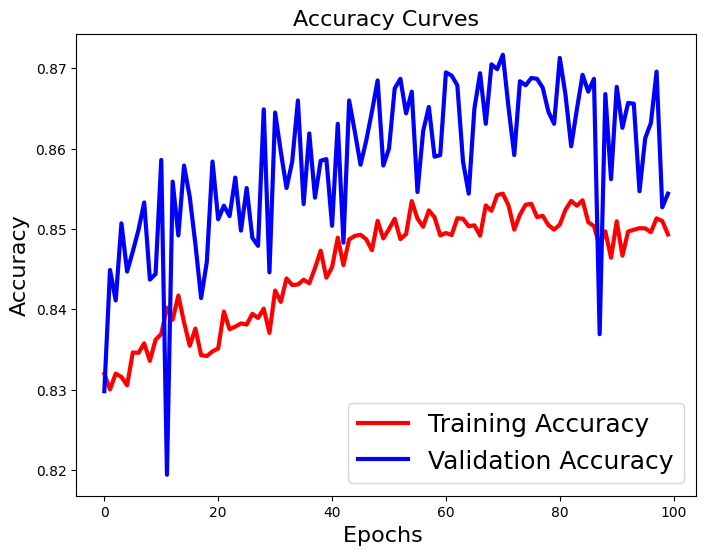

In [ ]:
show_graphs(history1f)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Accuracy: 87.13%
F1 Score: 83.44%



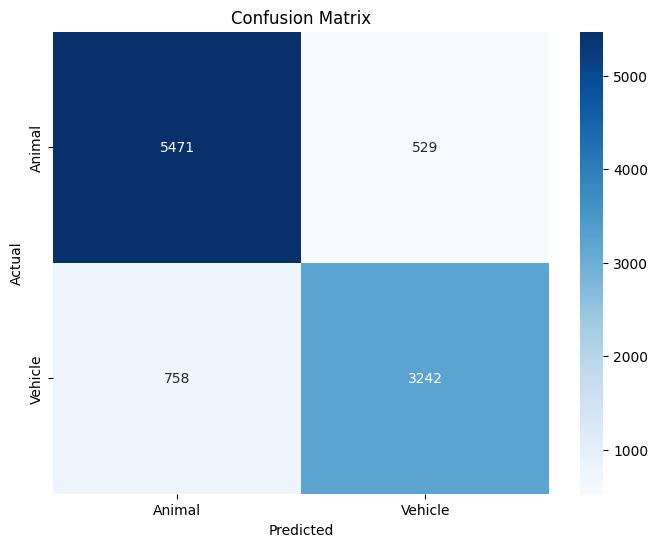

In [ ]:
show_conf_matrix('model1f.keras', X_test_scaled, y_test_bin)

### Comparing all ANNs

In [ ]:
models = []
sets = [(X_train_scaled, X_test_scaled), (X_train, X_test), (X_train_scaled, X_test_scaled),
        (X_train, X_test), (X_train, X_test), (X_train_scaled, X_test_scaled)]
for i, alp in enumerate(['a', 'b', 'c', 'd', 'e', 'f']):
  train_acc, train_f1, _ = get_acc_f1('model1'+alp+'.keras', sets[i][0], y_train_bin)
  test_acc, test_f1, _ = get_acc_f1('model1'+alp+'.keras', sets[i][1], y_test_bin)
  m = Model('Model 1'+alp, train_acc, train_f1, test_acc, test_f1)
  models.append(m)

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [ ]:
draw_table(models)

,Train Accuracy,Train F1-Score,Test Accuracy,Test F1-Score
Model Name,,,,
Model 1a,92.07,89.82,87.25,83.47
Model 1b,90.72,88.36,88.01,84.94
Model 1c,91.14,88.55,87.71,84.04
Model 1d,92.18,90.17,86.07,82.51
Model 1e,88.83,85.36,85.64,81.09
Model 1f,89.04,85.92,87.13,83.44


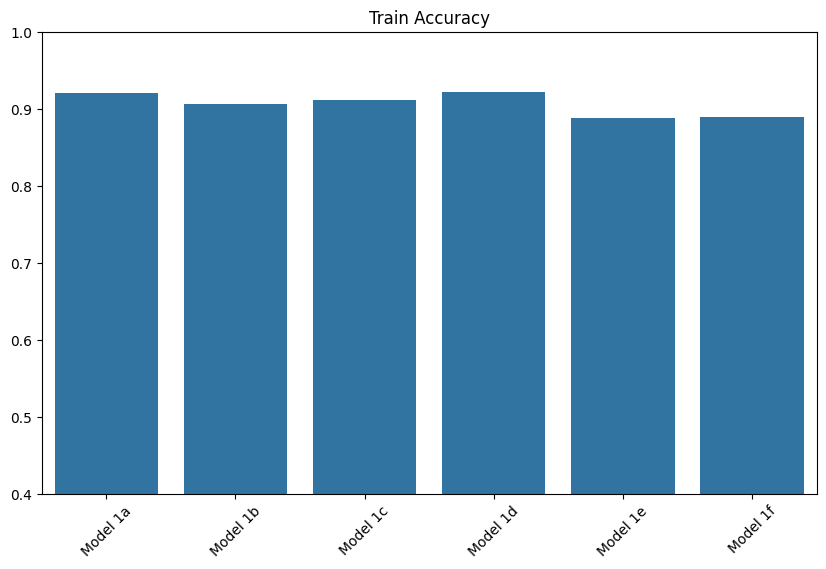

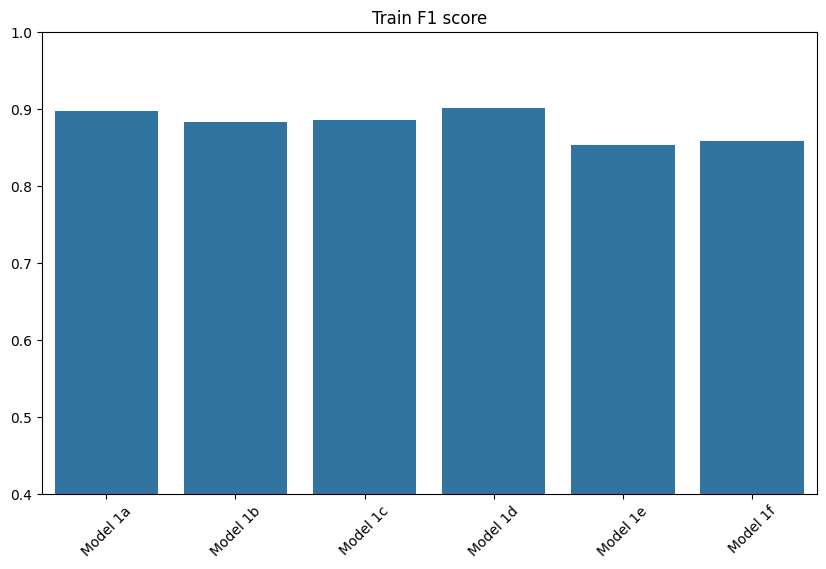

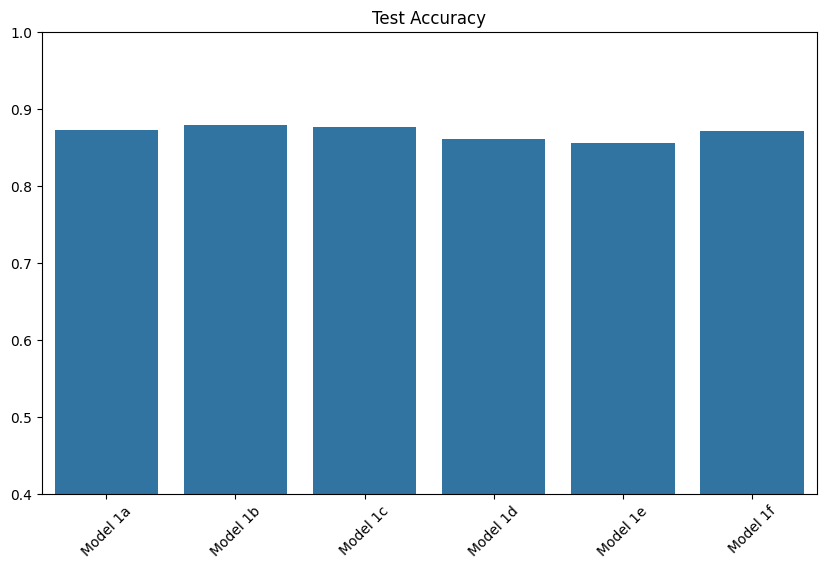

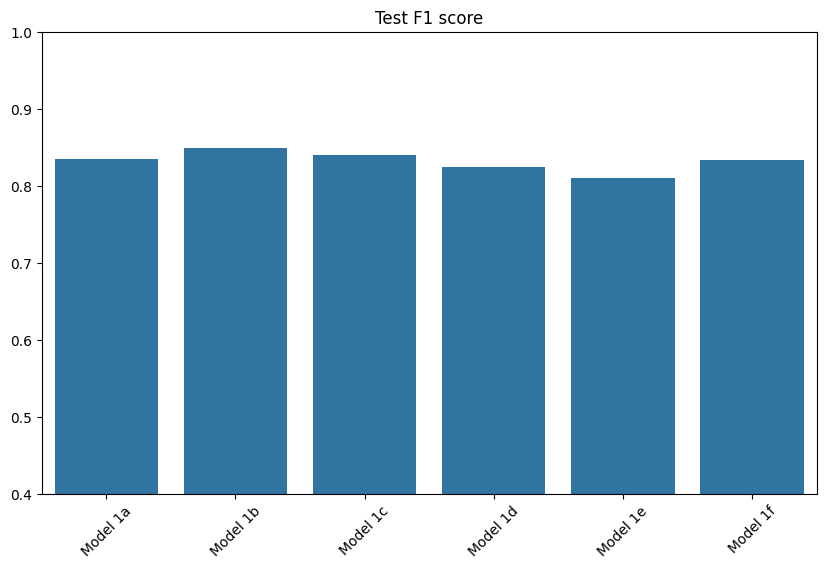

In [ ]:
plot_scores(models)

#### Having fun with Transfer Learning and a different dataset split ratio :)

In [ ]:
new_X_train_t = torch.from_numpy(new_X_train).float().permute(0, 3, 1, 2)  # (N, 3, 32, 32)
new_y_train_t = torch.from_numpy(new_y_train_bin).float()  # Binary labels: 0 or 1

new_X_test_t = torch.from_numpy(new_X_test).float().permute(0, 3, 1, 2)
new_y_test_t = torch.from_numpy(new_y_test_bin).float()

mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)

new_X_train_t = (new_X_train_t / 255.0 - mean) / std  # Scale [0,255] → [0,1], then normalize
new_X_test_t = (new_X_test_t / 255.0 - mean) / std

new_train_dataset = torch.utils.data.TensorDataset(new_X_train_t, new_y_train_t)
new_test_dataset = torch.utils.data.TensorDataset(new_X_test_t, new_y_test_t)

In [ ]:
model_pretrained = resnet18(pretrained=True)

# Modify the first convolutional layer to accept 32x32 inputs
model_pretrained.conv1 = torch.nn.Conv2d(
    in_channels=3,          # CIFAR-10 has 3 channels (RGB)
    out_channels=64,        # Same as original ResNet-18
    kernel_size=3,          # Smaller kernel for smaller images (was 7x7)
    stride=1,               # No stride to retain spatial resolution
    padding=1,              # Padding to maintain 32x32 output
    bias=False
)

# Remove the max-pooling layer (reduces downsampling)
model_pretrained.maxpool = torch.nn.Identity()

model_pretrained.fc = torch.nn.Linear(model_pretrained.fc.in_features, 1) # for binary output

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 132MB/s]


In [ ]:
print(model_pretrained)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): Identity()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), p

There is a total of eighteen layers in the network (17 convolutional layers, a fully-connected layer and an additional softmax layer to perform classification task).

In [ ]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet stats
        std=[0.229, 0.224, 0.225]
    )
])

In [ ]:
# Freeze all layers
for param in model_pretrained.parameters():
    param.requires_grad = False

# Unfreeze the modified conv1 and classifier
for param in model_pretrained.conv1.parameters():
    param.requires_grad = True
for param in model_pretrained.fc.parameters():
    param.requires_grad = True

In [ ]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model_pretrained.parameters()),  # Train only unfrozen layers
    lr=0.001
)

In [ ]:
# Create dataloaders
batch_size = 64

train_loader = torch.utils.data.DataLoader(
    new_train_dataset,
    batch_size=batch_size,
    shuffle=True,  # Shuffle training data
    num_workers=2  # Parallel data loading
)

test_loader = torch.utils.data.DataLoader(
    new_test_dataset,
    batch_size=batch_size,
    shuffle=False,  # No need to shuffle test data
    num_workers=2
)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_pretrained.to(device)

# Training loop
for epoch in range(10):
    model_pretrained.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.float().to(device)
        optimizer.zero_grad()
        outputs = model_pretrained(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validation
    model_pretrained.eval()
    correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.float().to(device)
            outputs = model_pretrained(images).squeeze()
            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct += (preds == labels).sum().item()

    accuracy = correct / len(new_test_dataset)
    print(f"Epoch {epoch+1}, Test Accuracy: {accuracy:.2f}%")

Epoch 1, Test Accuracy: 33.52%
Epoch 2, Test Accuracy: 33.66%
Epoch 3, Test Accuracy: 33.33%
Epoch 4, Test Accuracy: 33.37%
Epoch 5, Test Accuracy: 33.47%
Epoch 6, Test Accuracy: 33.30%
Epoch 7, Test Accuracy: 33.76%
Epoch 8, Test Accuracy: 33.57%
Epoch 9, Test Accuracy: 33.59%
Epoch 10, Test Accuracy: 33.64%


This model needs to be tweaked further to to be trained properly.

### Model 2: Shallow Parametric Model

#### 2a. Logistic Regression(Gray-scale dataset)




In [ ]:
model2a = LogisticRegression(max_iter=1000)
model2a.fit(X_train_gray_flat_scale, y_train_bin)

LogisticRegression(max_iter=1000)

In [ ]:
with open('model2a.pkl', 'wb') as file:
    pickle.dump(model2a, file)

In [ ]:
pred2a = model2a.predict(X_test_gray_flat_scale)

In [ ]:
print(classification_report(y_test_bin, pred2a))

              precision    recall  f1-score   support

       False       0.74      0.83      0.78      6000
        True       0.69      0.55      0.61      4000

    accuracy                           0.72     10000
   macro avg       0.71      0.69      0.70     10000
weighted avg       0.72      0.72      0.71     10000




Accuracy: 72.09%
F1 Score: 61.23%



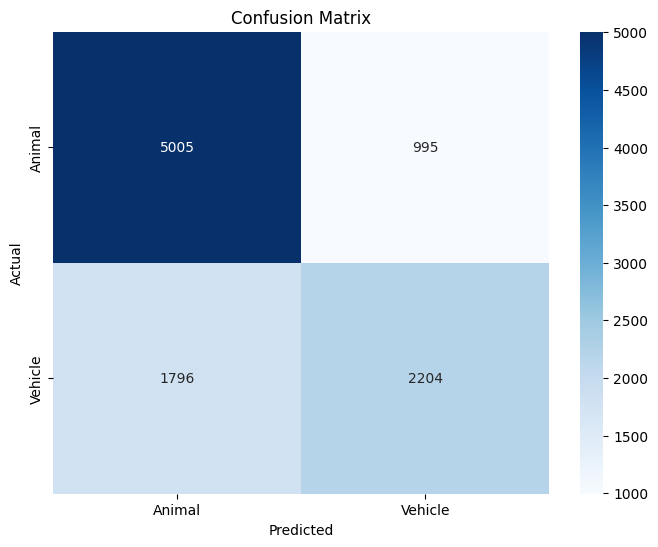

In [ ]:
show_conf_matrix('model2a.pkl', X_test_gray_flat_scale, y_test_bin)

#### 2b. Logistic Regression(RGB scaled dataset)



In [ ]:
model2b = LogisticRegression(max_iter=1000)
model2b.fit(X_train_scale, y_train_bin)

LogisticRegression(max_iter=1000)

In [ ]:
with open('model2b.pkl', 'wb') as file:
    pickle.dump(model2b, file)

In [ ]:
pred2b = model2b.predict(X_test_scale)

In [ ]:
print(classification_report(y_test_bin, pred2b))

              precision    recall  f1-score   support

       False       0.83      0.87      0.85      6000
        True       0.79      0.74      0.76      4000

    accuracy                           0.82     10000
   macro avg       0.81      0.80      0.81     10000
weighted avg       0.82      0.82      0.82     10000




Accuracy: 81.67%
F1 Score: 76.24%



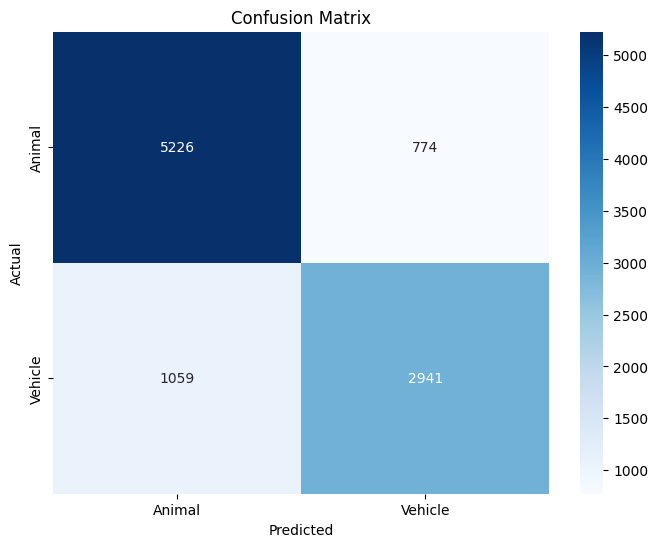

In [ ]:
show_conf_matrix('model2b.pkl', X_test_scale, y_test_bin)

#### 2c. Logistic Regression(PCA applied dataset)



In [ ]:
model2c = LogisticRegression(max_iter=1000)
model2c.fit(X_recovered, y_train_bin)

LogisticRegression(max_iter=1000)

In [ ]:
with open('model2c.pkl', 'wb') as file:
    pickle.dump(model2c, file)

In [ ]:
pred2c = model2c.predict(X_test_recovered)

In [ ]:
print(classification_report(y_test_bin, pred2c))

              precision    recall  f1-score   support

       False       0.74      0.84      0.79      6000
        True       0.70      0.55      0.62      4000

    accuracy                           0.73     10000
   macro avg       0.72      0.70      0.70     10000
weighted avg       0.72      0.73      0.72     10000




Accuracy: 72.58%
F1 Score: 61.76%



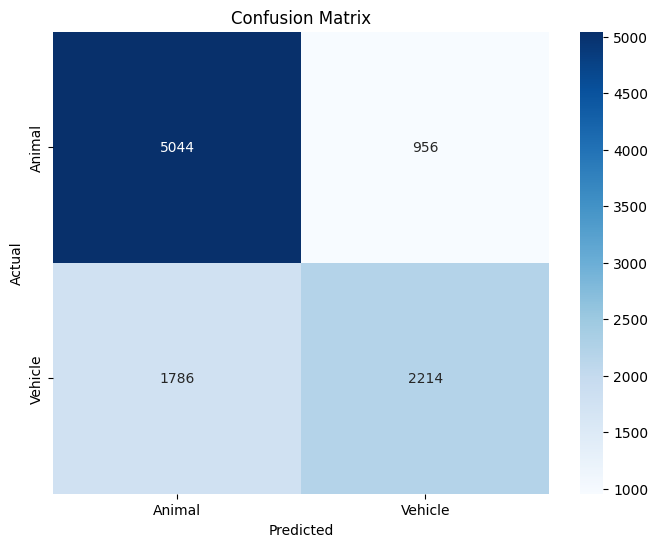

In [ ]:
show_conf_matrix('model2c.pkl', X_test_recovered, y_test_bin)

<img src="https://i.pinimg.com/1200x/f2/09/9a/f2099ab7aa48240b8da2b8e618068023.jpg" width="400" height="400">

#### 2d. Logistic Regression(liblinear Solver) with RGB scaled images



In [ ]:
model2d = regression=LogisticRegression(solver="liblinear",random_state=0)
model2d.fit(X_train_scale, y_train_bin)

LogisticRegression(random_state=0, solver='liblinear')

In [ ]:
with open('model2d.pkl', 'wb') as file:
    pickle.dump(model2d, file)

In [ ]:
pred2d = model2d.predict(X_test_scale)

In [ ]:
print(classification_report(y_test_bin, pred2d))

              precision    recall  f1-score   support

       False       0.83      0.87      0.85      6000
        True       0.79      0.73      0.76      4000

    accuracy                           0.82     10000
   macro avg       0.81      0.80      0.81     10000
weighted avg       0.82      0.82      0.82     10000




Accuracy: 81.65%
F1 Score: 76.22%



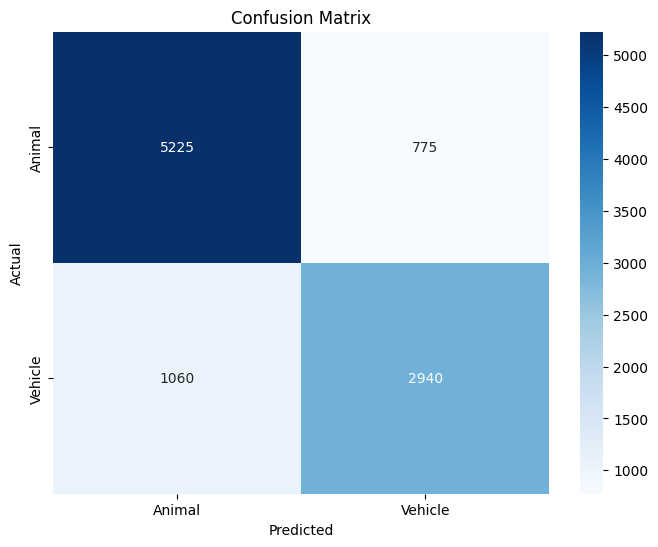

In [ ]:
show_conf_matrix('model2d.pkl', X_test_scale, y_test_bin)

### Comparing All Shallow Models

In [ ]:
models = []
sets = [(X_train_gray_flat_scale, X_test_gray_flat_scale), (X_train_scale, X_test_scale),
        (X_recovered, X_test_recovered), (X_train_scale, X_test_scale)]
for i, alp in enumerate(['a', 'b', 'c', 'd']):
  train_acc, train_f1, _ = get_acc_f1('model2'+alp+'.pkl', sets[i][0], y_train_bin)
  test_acc, test_f1, _ = get_acc_f1('model2'+alp+'.pkl', sets[i][1], y_test_bin)
  m = Model('Model 2'+alp, train_acc, train_f1, test_acc, test_f1)
  models.append(m)

In [ ]:
draw_table(models)

,Train Accuracy,Train F1-Score,Test Accuracy,Test F1-Score
Model Name,,,,
Model 2a,73.76,63.33,72.09,61.23
Model 2b,83.54,78.74,81.67,76.24
Model 2c,73.21,62.33,72.58,61.76
Model 2d,83.64,78.87,81.65,76.22


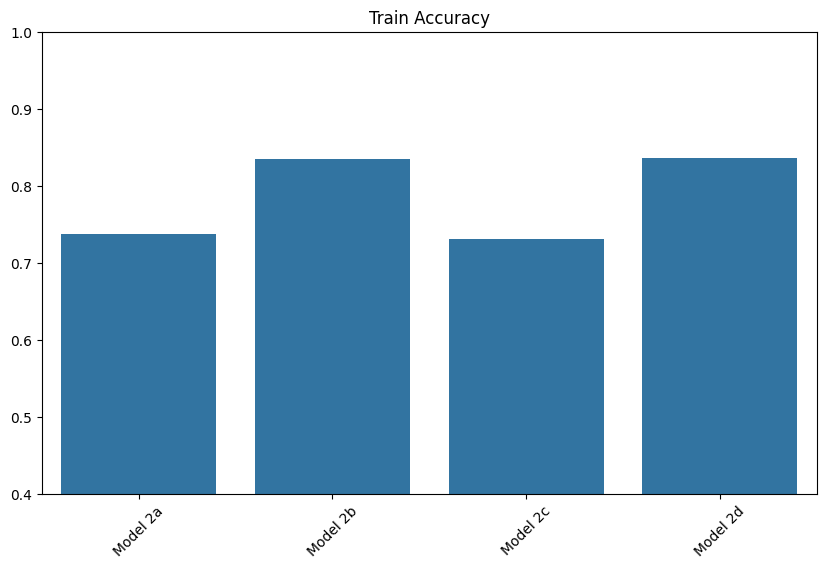

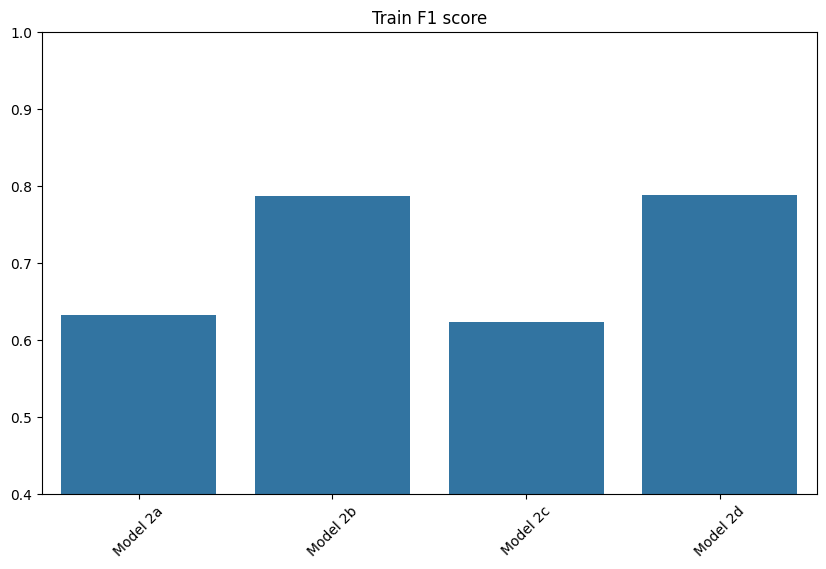

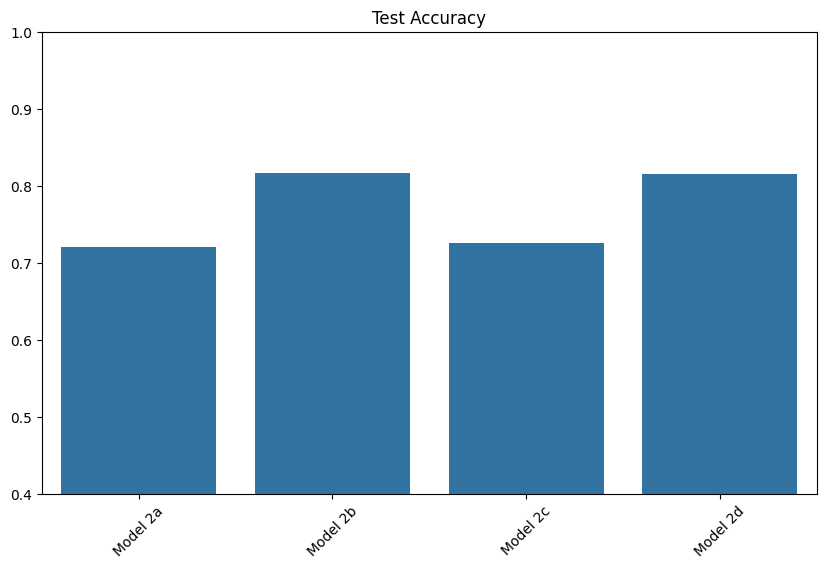

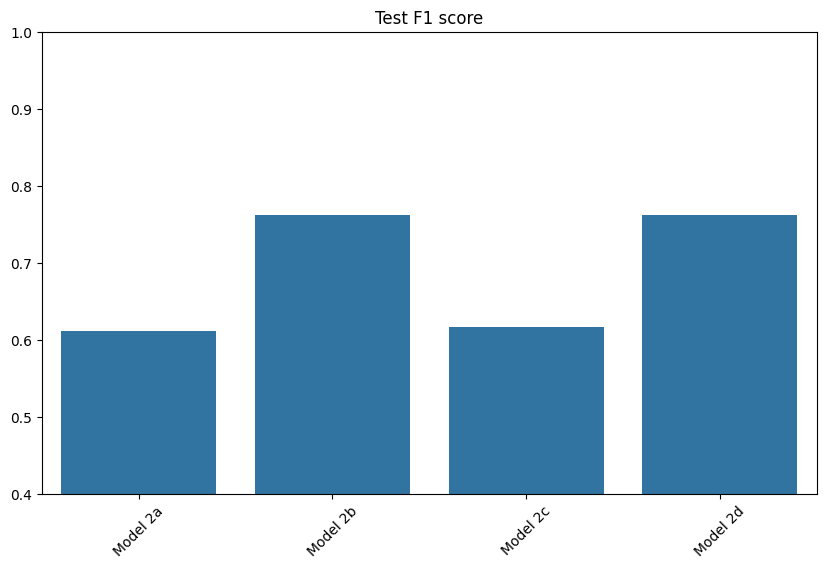

In [ ]:
plot_scores(models)

#### Experimenting on a different dataset split ratio

In [ ]:
model2z = regression=LogisticRegression(random_state=42)
model2z.fit(new_X_train_scale, new_y_train_bin)

LogisticRegression(random_state=42)

In [ ]:
with open('model2z.pkl', 'wb') as file:
    pickle.dump(model2z, file)

In [ ]:
pred2z = model2z.predict(new_X_test_scale)

In [ ]:
print(classification_report(new_y_test_bin, pred2z))

              precision    recall  f1-score   support

       False       0.83      0.87      0.85     11947
        True       0.79      0.74      0.77      8053

    accuracy                           0.82     20000
   macro avg       0.81      0.81      0.81     20000
weighted avg       0.82      0.82      0.82     20000




Accuracy: 81.83%
F1 Score: 76.7%



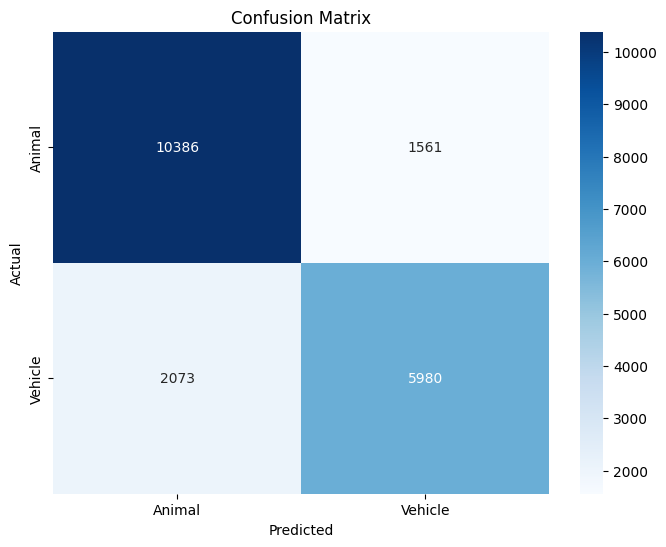

In [ ]:
show_conf_matrix('model2z.pkl', new_X_test_scale, new_y_test_bin)

Not as good :(

### Model 3: Non-Parametric Model

#### 3a. KNN Classifier(with n = 3) and gray scale images

In [ ]:
model3a = KNeighborsClassifier(n_neighbors=3)
model3a.fit(X_train_gray_flat_scale, y_train_bin)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
with open('model3a.pkl', 'wb') as file:
    pickle.dump(model3a, file)

In [ ]:
pred3a = model3a.predict(X_test_gray_flat_scale)

In [ ]:
print(classification_report(y_test_bin, pred3a))

              precision    recall  f1-score   support

       False       0.77      0.81      0.79      6000
        True       0.69      0.64      0.66      4000

    accuracy                           0.74     10000
   macro avg       0.73      0.72      0.73     10000
weighted avg       0.74      0.74      0.74     10000




Accuracy: 74.07%
F1 Score: 66.27%



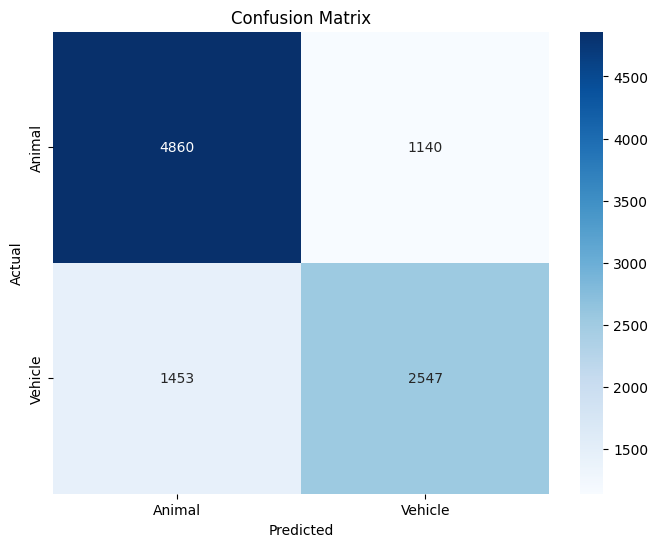

In [ ]:
show_conf_matrix('model3a.pkl', X_test_gray_flat_scale, y_test_bin)

#### 3b. KNN Classifier(with n = 5) and RGB images

In [ ]:
model3b = KNeighborsClassifier(n_neighbors=5)
model3b.fit(X_train_scale, y_train_bin)

KNeighborsClassifier()

In [ ]:
with open('model3b.pkl', 'wb') as file:
    pickle.dump(model3b, file)

In [ ]:
pred3b = model3b.predict(X_test_scale)

In [ ]:
print(classification_report(y_test_bin, pred3b))

              precision    recall  f1-score   support

       False       0.80      0.91      0.85      6000
        True       0.83      0.66      0.73      4000

    accuracy                           0.81     10000
   macro avg       0.81      0.78      0.79     10000
weighted avg       0.81      0.81      0.80     10000




Accuracy: 80.79%
F1 Score: 73.3%



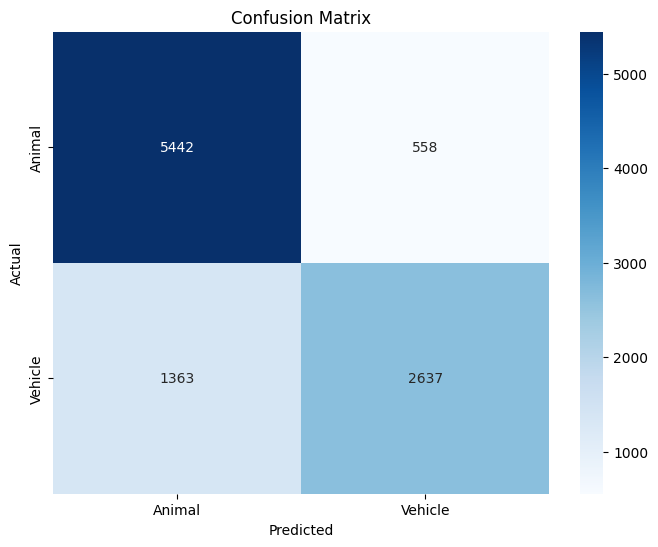

In [ ]:
show_conf_matrix('model3b.pkl', X_test_scale, y_test_bin)

#### 3c. KNN Classifier(with n = 5) and PCA gray-scaled features

In [ ]:
model3c = KNeighborsClassifier(n_neighbors=5)
model3c.fit(X_reduced, y_train_bin)

KNeighborsClassifier()

In [ ]:
with open('model3c.pkl', 'wb') as file:
    pickle.dump(model3c, file)

In [ ]:
pred3c = model3c.predict(X_test_reduced)

In [ ]:
print(classification_report(y_test_bin, pred3c))

              precision    recall  f1-score   support

       False       0.71      0.81      0.76      6000
        True       0.64      0.50      0.56      4000

    accuracy                           0.69     10000
   macro avg       0.67      0.66      0.66     10000
weighted avg       0.68      0.69      0.68     10000




Accuracy: 68.58%
F1 Score: 56.06%



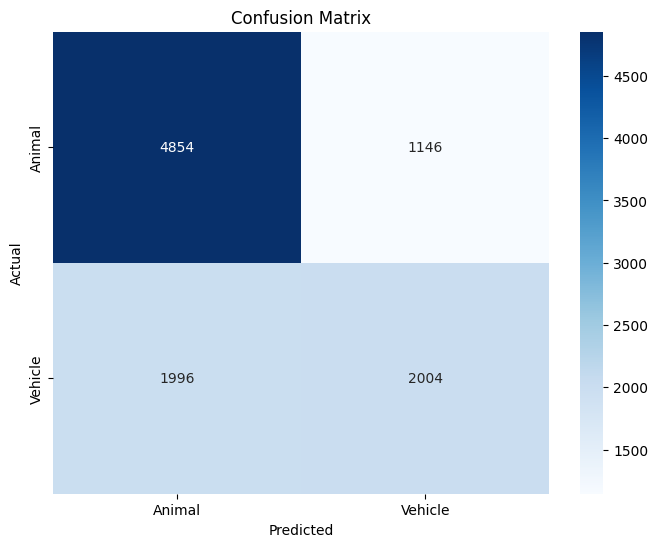

In [ ]:
show_conf_matrix('model3c.pkl', X_test_reduced, y_test_bin)

### Comparing All Non-Parametric Models

In [ ]:
models = []
sets = [(X_train_gray_flat_scale, X_test_gray_flat_scale), (X_train_scale, X_test_scale),
        (X_reduced, X_test_reduced)]
for i, alp in enumerate(['a', 'b', 'c']):
  train_acc, train_f1, _ = get_acc_f1('model3'+alp+'.pkl', sets[i][0], y_train_bin)
  test_acc, test_f1, _ = get_acc_f1('model3'+alp+'.pkl', sets[i][1], y_test_bin)
  m = Model('Model 3'+alp, train_acc, train_f1, test_acc, test_f1)
  models.append(m)

In [ ]:
draw_table(models)

,Train Accuracy,Train F1-Score,Test Accuracy,Test F1-Score
Model Name,,,,
Model 3a,85.73,81.48,74.07,66.27
Model 3b,85.40,80.01,80.79,73.30
Model 3c,83.23,77.38,68.58,56.06


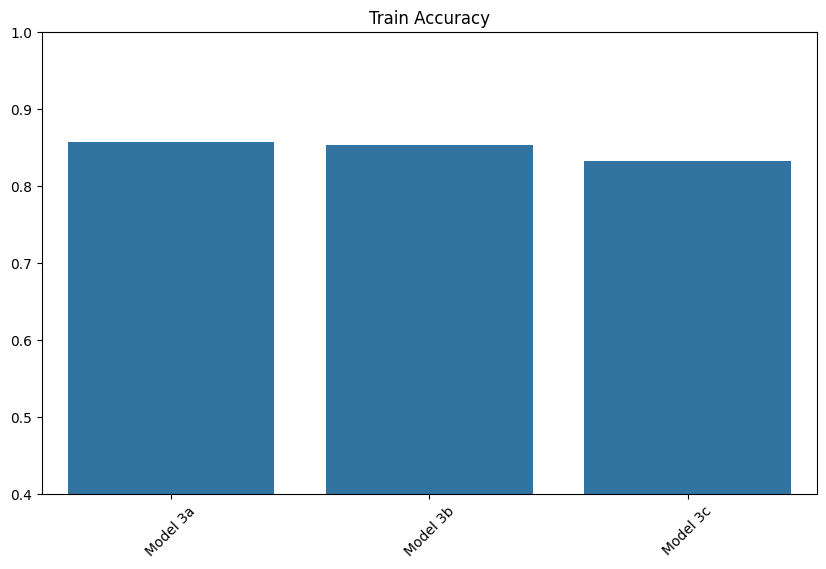

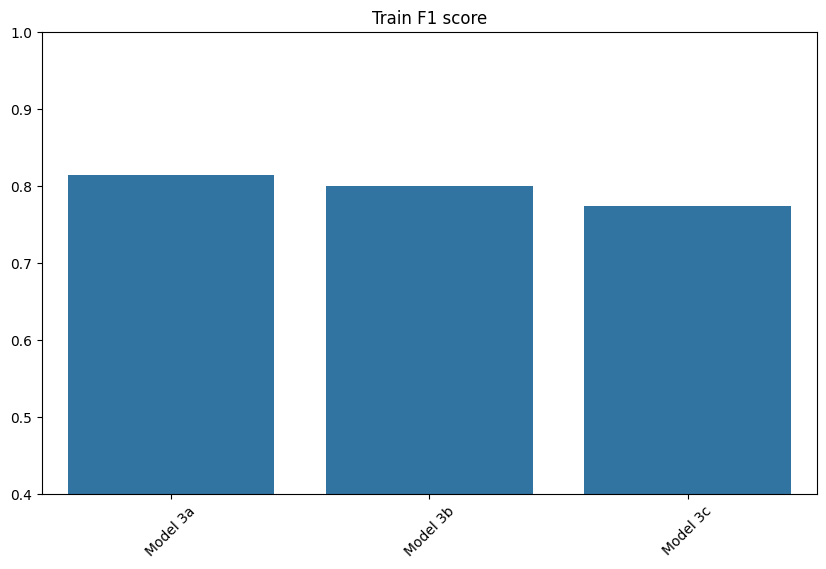

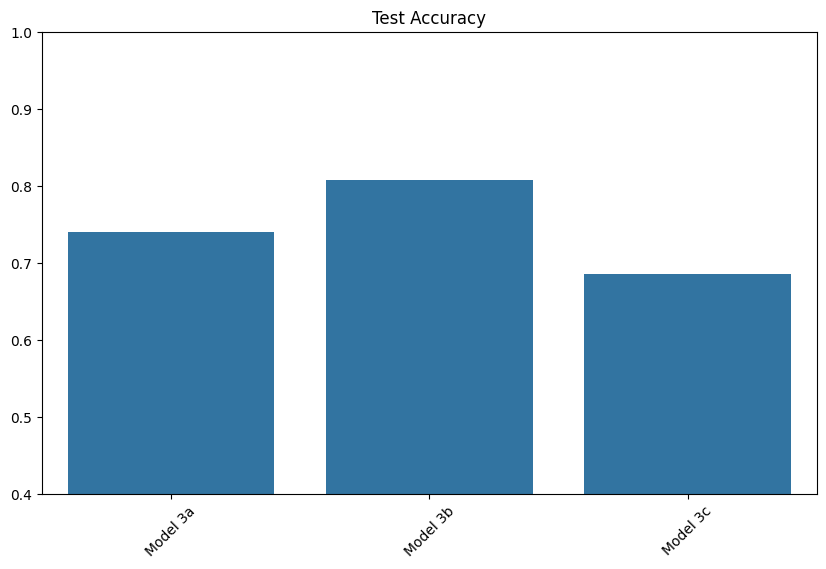

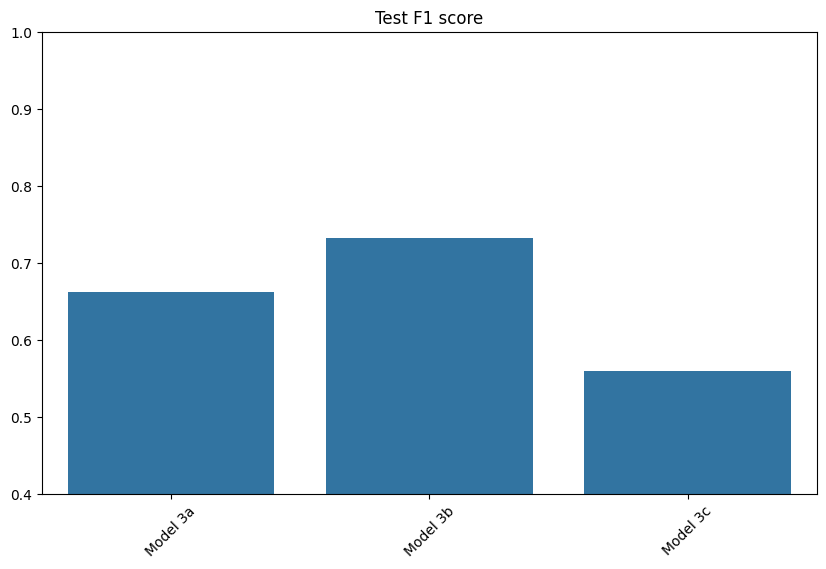

In [ ]:
plot_scores(models)

#### Experimenting on a different dataset split ratio

In [ ]:
model3z = KNeighborsClassifier(n_neighbors=3)
model3z.fit(new_X_train_scale, new_y_train_bin)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
with open('model3z.pkl', 'wb') as file:
    pickle.dump(model3z, file)

In [ ]:
pred3z = model3z.predict(new_X_test_scale)

In [ ]:
print(classification_report(new_y_test_bin, pred3z))

              precision    recall  f1-score   support

       False       0.79      0.90      0.84     11947
        True       0.81      0.65      0.72      8053

    accuracy                           0.80     20000
   macro avg       0.80      0.77      0.78     20000
weighted avg       0.80      0.80      0.79     20000




Accuracy: 79.84%
F1 Score: 72.18%



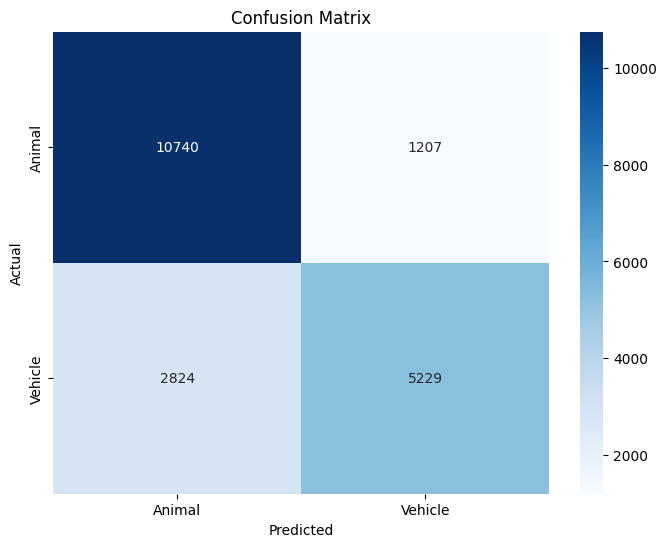

In [ ]:
show_conf_matrix('model3z.pkl', new_X_test_scale, new_y_test_bin)

## Conclusion

- ANNs like model 1a, 1d, and 1e seem to perform much better than other models.

- In Parametric model, 2b performs slightly better.

- In Non-Parametric models, model 3b performs a bit better too. But it is still not trained well enough.


## User Interface

In [ ]:
import io
import numpy as np
from PIL import Image
import ipywidgets as widgets
from IPython.display import display, HTML

selected_index = 0

# load all models
pred_model_1a = load_model('model1a.keras')
pred_model_1b = load_model('model1b.keras')
with open('model2b.pkl', 'rb') as file:
  pred_model_2b = pickle.load(file)

# Function to add a frame around the selected image
def select_image(index):
    # Clear previous frames
    for image_widget in right_container.children:
        image_widget.layout.border = None

    # Add a frame around the selected image
    image_widget = right_container.children[index]
    image_widget.layout.border = '6px solid red'


# Create the left container for progress bars and image selection dropdown
left_container = widgets.VBox(
    [
        widgets.HTML(
    value='<div style="font-size: 24px; font-weight: bold; color: blue;">Probability of Vehicle</div>',
    layout=widgets.Layout(margin='10px')
),
        widgets.FloatProgress(value=0.0, min=0.0, max=1.0, description='Model 1a:'),
        widgets.FloatProgress(value=0.0, min=0.0, max=1.0, description='Model 1b:'),
        widgets.FloatProgress(value=0.0, min=0.0, max=1.0, description='Model 2b:'),
              widgets.HTML(
    value='<div style="font-size: 24px; font-weight: bold; color: blue;">Probability of Animal</div>',
    layout=widgets.Layout(margin='10px')
),
        widgets.FloatProgress(value=0.0, min=0.0, max=1.0, description='Model 1a:'),
        widgets.FloatProgress(value=0.0, min=0.0, max=1.0, description='Model 1b:'),
        widgets.FloatProgress(value=0.0, min=0.0, max=1.0, description='Model 2b:'),
    ],
    layout=widgets.Layout(
        display='flex',
        justify_content='center',
        flex_direction='column',
        align_items='center',
        overflow='auto',
        width='800px',
        border='solid',
        background_color='gray'
    ),
)

# Create a list to store the image widgets
image_widgets = []

# Create a dropdown widget for image selection
image_selection_dropdown = widgets.Dropdown(
    options=list(range(50)),  # Assuming there are 50 images
    description='Select Image:',
)

# Function to handle image selection from the dropdown
def image_dropdown_handler(change):
    global selected_index
    selected_index = change.new
    select_image(selected_index)

image_selection_dropdown.observe(image_dropdown_handler, names='value')

# Add the image selection dropdown to the left container
left_container.children += (image_selection_dropdown,)

# Create the right container for images in columns
right_container = widgets.VBox(
    layout=widgets.Layout(
        overflow='auto',
        border='solid',
        height='450px',
        width='230px'
    )
)

# Create an image widget for each image
for i, image in enumerate(X_test[0:50]):
    # Convert the image to PIL format
    image = Image.fromarray(np.uint8(image))

    # Create an Image widget
    image_widget = widgets.Image(format='png')
    image_widget.index = i  # Assign an index to the image widget

    # Set the style of the image widget
    image_widget.layout.width = '150px'
    image_widget.layout.height = '150px'
    image_widget.layout.margin = '5px'

    # Convert the image to bytes
    with io.BytesIO() as buffer:
        image.save(buffer, 'png',)
        buffer.seek(0)
        image_bytes = buffer.read()

    # Update the image widget with the image data
    image_widget.value = image_bytes

    # Add the image widget to the right container
    right_container.children += (image_widget,)
    image_widgets.append(image_widget)  # Add the image widget to the list

# Display the containers side by side
display(widgets.HBox([left_container, right_container]))


# Function to update the value of FloatProgress widgets on button click
def update_progress_values(change):
    image = X_test[selected_index]
    image_scaled = X_test_scaled[selected_index]

    pr = pred_model_1a.predict(image_scaled.reshape(1, 32, 32, 3))
    left_container.children[1].value = np.squeeze(pr)
    left_container.children[5].value = 1-left_container.children[1].value

    pr = pred_model_1b.predict(image.reshape(1, 32, 32, 3))
    left_container.children[2].value = np.squeeze(pr)
    left_container.children[6].value = 1-left_container.children[2].value

    pr = pred_model_2b.predict(image_scaled.reshape(1, 3072))
    left_container.children[3].value = np.squeeze(pr)
    left_container.children[7].value = 1-left_container.children[3].value


# Create a button to trigger the update_progress_values function
update_button = widgets.Button(description='Predict')
update_button.on_click(update_progress_values)

# Add the update button to the left container
left_container.children += (update_button, )

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


## Incremental Learning of Model 1a

In [ ]:
import numpy as np
import ipywidgets as widgets
from IPython.display import display
from PIL import Image
import io
from tensorflow.keras.models import load_model, clone_model
import tensorflow as tf

# Load or initialize model
model = load_model('model1a.keras')
incremental_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=incremental_optimizer,
             loss='binary_crossentropy',
             metrics=['accuracy'])
# tf.config.run_functions_eagerly(True)
    # Clone model for incremental training
new_model = clone_model(model)
new_model.set_weights(model.get_weights())
new_model.compile(optimizer=incremental_optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# Initialize incremental dataset
training_samples = []  # Stores (image, label_widget) tuples
class_names = ['Animal', 'Vehicle']

# ===================== UI Components =====================
upload = widgets.FileUpload(
    accept='.png,.jpg,.jpeg',
    multiple=True,
    description='Upload Images'
)

train_button = widgets.Button(description='Train Model')
progress = widgets.FloatProgress(value=0.0, min=0.0, max=1.0, description='Training:')
status = widgets.HTML(value="<b>Status:</b> Ready")
image_display = widgets.VBox(layout=widgets.Layout(overflow='auto', max_height='400px'))
save_button = widgets.Button(
    description='Save Model',
    button_style='success',
    icon='floppy-disk'
)

# ===================== Core Functions =====================
def preprocess_image(content):
    img = Image.open(io.BytesIO(content)).convert('RGB')
    img = img.resize((32, 32))
    img_array = np.array(img) / 255.0
    return img_array

def on_upload(change):
    global training_samples
    training_samples.clear()
    image_display.children = ()  # Clear previous images

    for name, content in upload.value.items():
        # Create image preview and label selector
        img = preprocess_image(content['content'])
        img_widget = widgets.Image(value=content['content'], format='jpg', width=64, height=64)
        label_dropdown = widgets.Dropdown(
            options=class_names,
            value=class_names[0],
            layout=widgets.Layout(width='150px')
        )

        # Store both the preprocessed image and widget
        training_samples.append({
            'image': img,
            'label_widget': label_dropdown
        })

        # Create a container for each image+label pair
        container = widgets.HBox([
            img_widget,
            label_dropdown
        ], layout=widgets.Layout(margin='5px 0'))

        image_display.children += (container,)

    status.value = f"<b>Status:</b> Uploaded {len(upload.value)} images. Select labels and click Train."

def on_train(b):
    if not training_samples:
        status.value = "<b>Status:</b> No images to train!"
        return

    # Collect images and labels
    X_train = np.array([sample['image'] for sample in training_samples])
    y_train = np.array([0 if w.value == 'Animal' else 1 for w in [s['label_widget'] for s in training_samples]])



    # Train with progress
    progress.value = 0
    epochs = 10
    batch_size = 8

    for epoch in range(epochs):
        history = new_model.fit(X_train, y_train,
                     batch_size=batch_size,
                     verbose=0)
        progress.value = (epoch + 1) / epochs
        status.value = f"Accuracy:{history.history['accuracy'][0]} Loss: {history.history['loss'][0]}"

    # Update main model
    model.set_weights(new_model.get_weights())

    # Reset UI
    training_samples.clear()
    image_display.children = ()
    status.value = f"<b>Status:</b> Trained on {len(X_train)} samples. Upload new images to continue."

def on_save(b):
    try:
        model.save('model1a_new.keras')
        status.value = "<b>Status:</b> Model saved as 'model1a_new.keras'!"
    except Exception as e:
        status.value = f"<b>Error saving model:</b> {str(e)}"

# ===================== Event Handlers =====================
upload.observe(on_upload, names='value')
train_button.on_click(on_train)
save_button.on_click(on_save)

# ===================== Assemble UI =====================
controls = widgets.VBox([
    widgets.HTML("<h2>Incremental Learning Interface</h2>"),
    upload,
    train_button,
    progress,
    status
])

display(widgets.HBox([
    controls,
    widgets.VBox([
        widgets.HTML("<h3>Label Images</h3>"),
        image_display
    ])
]))

display(widgets.VBox([
    save_button,
]))



### Testing New Model

In [ ]:
pred_model_1a = load_model('model1a.keras')
pred_model_1a_new = load_model('model1a_new.keras')

# ===================== New Model Evaluation Section =====================
eval_container = widgets.VBox(
    layout=widgets.Layout(
        border='2px solid green',
        padding='10px',
        margin='20px 0',
        width='600px'
    )
)

# Upload widget for evaluation
eval_upload = widgets.FileUpload(
    accept='image/*',
    multiple=False,
    description='Evaluate New Model'
)

# Image preview and results display
eval_image = widgets.Image(layout=widgets.Layout(width='150px', height='150px'))
eval_results = widgets.HTML(value="<h4>Prediction Results:</h4>")

# Model selection dropdown
model_selector = widgets.Dropdown(
    options=[('Old Model 1a', 0), ('New Model 1a', 0)],
    value=0,
    description='Select Model:'
)

def handle_eval_upload(change):
    if not eval_upload.value:
        return

    try:
        # Process uploaded image
        content = list(eval_upload.value.values())[0]['content']
        img = Image.open(io.BytesIO(content))

        # Convert to CIFAR-10 format
        img = img.resize((32, 32)).convert('RGB')
        img_array = np.array(img) / 255.0

        # Show preview
        with io.BytesIO() as buffer:
            img.save(buffer, format='PNG')
            eval_image.value = buffer.getvalue()

        # Get predictions
        model_idx = model_selector.value
        models = [pred_model_1a, pred_model_1a_new]
        selected_model = models[model_idx]

        prediction = selected_model.predict(img_array.reshape(1, 32, 32, 3))

        vehicle_prob = np.squeeze(prediction)
        animal_prob = 1 - vehicle_prob

        # Format results
        eval_results.value = f"""
        <h4>Prediction Results ({model_selector.options[model_idx][0]}):</h4>
        <div style="font-size: 16px; margin: 10px 0">
            🚗 Vehicle Probability: {vehicle_prob:.2%}<br>
            🐾 Animal Probability: {animal_prob:.2%}
        </div>
        <div style="color: {'red' if vehicle_prob > 0.5 else 'green'}; font-weight: bold">
            Prediction: {'VEHICLE' if vehicle_prob > 0.5 else 'ANIMAL'}
        </div>
        """

    except Exception as e:
        eval_results.value = f"<div style='color: red'>Error: {str(e)}</div>"
    finally:
        eval_upload.value.clear()

# Assemble evaluation section
eval_container.children = [
    widgets.HTML("<h3 style='color: green'>Evaluate New Images</h3>"),
    widgets.HBox([eval_upload, model_selector]),
    widgets.HBox([eval_image, eval_results])
]

# Add to main display
display(eval_container)

# Attach handler
eval_upload.observe(handle_eval_upload, names='value')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
